# Cross-Assay Integrative Analyses

In [1]:
import polars as pl
import os
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from venn import venn
import sys
from yogiroc import *
sys.path.append("../../2_individual_assay_analyses")
from utils import *
%matplotlib inline

## 1. Loading allele information

### 1.1 VarChAMP Dataset Alleles Merged with Pillar Project

In [2]:
pillar_clinvar_df = pl.read_csv(
    "../../1_allele_collection/1_inputs/raw_inputs/pillar_data/final_pillar_data_with_clinvar_gnomad_wREVEL_wAM_gold_standards_080425.csv", 
    schema_overrides={
        "Chrom": pl.String, 
        'aa_pos': pl.String, 
        'auth_reported_score': pl.String
    },
    infer_schema_length=10000
).with_columns(
    pl.col("Gene").str.replace_all(r"[^a-zA-Z0-9]", "").alias("Gene"),
    pl.col("hgvs_p").str.replace_all(r"[^a-zA-Z0-9\.]", "").alias("hgvs_p")
).with_columns(
    pl.col("Gene").str.replace_all("CHK2", "CHEK2").alias("Gene"),
    pl.col("Chrom").cast(pl.String).str.strip_chars().alias("Chrom"),
    pl.col("hg38_start").alias("nuc_loc"),
    pl.col("ref_allele").cast(pl.String).str.strip_chars().alias("ref_allele"),
    pl.col("alt_allele").cast(pl.String).str.strip_chars().alias("alt_allele")
).with_columns(
    pl.concat_str(
        [
            pl.col("Gene"),
            pl.col("hgvs_p").str.replace(r"^p\.", "") # remove leading "p." from hgvs_p
        ],
        separator="_"
    ).alias("gene_variant")
)

## filter the SNP variants only
pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
    (pl.col("consequence").str.contains("sense")) & \
    (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
    (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
).drop_nulls(subset="hgvs_p").with_columns(
    pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change"),
    pl.lit(True).alias("pillar_tested")
)
print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.sort(
    "gene_variant", "gnomad_MAF", descending=[False,False]
)
print("Number of unique genes Pillar ALL:", pillar_clinvar_df.unique(subset="Gene").shape[0])
print("Number of unique genes Pillar SNP:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])
print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))

Filtered missense/SNP pillar dataset shape: (121504, 104)
Number of unique genes Pillar ALL: 41
Number of unique genes Pillar SNP: 33
Number of unique gene variants: 61091


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant,aa_change,pillar_tested
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,bool
27534,"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""-0.1191""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Asp""","""Ala148Asp""",true
8857,"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""0.9495""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Asp""","""Ala148Asp""",true
27540,"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.1248""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.483509e6,"""ASPA_Ala148Gly""","""Ala148Gly""",true
8863,"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thyge

### 1.2 Imaging Data

In [12]:
img_sum_df = pl.read_csv("../1_inputs/imaging/imaging_analyses_summary_clinvar.tsv", separator="\t", infer_schema_length=100000)
img_sum_df = img_sum_df.with_columns(
    pl.col("gene_allele").alias("gene_variant"),
    pl.col("clinvar_clnsig_clean").fill_null("5_Others"),
    pl.col("nuc_loc").cast(pl.Int64)
).drop([c for c in img_sum_df.columns if c.endswith("_right")])
display(img_sum_df.head())

ppi_sum_df = pl.read_csv("../1_inputs/ppi/edgotyping_perturb_sum_stats.csv", infer_schema_length=1000000)
ppi_sum_df = ppi_sum_df.with_columns(
    pl.col("gene_variant").str.split("_").list.get(0).alias("Gene"),
    pl.col("gene_variant").alias("gene_allele"),
    pl.col("clinvar_clnsig_clean").fill_null("5_Others")
).with_columns(
    pl.col("clinvar_clnsig_clean").replace("6_No_ClinVar", "5_Others")
)
display(ppi_sum_df.head())

print(ppi_sum_df["Chrom", "nuc_loc", "ref_allele", "alt_allele", "clinvar_clnsig_clean"])
print(img_sum_df["Chrom", "nuc_loc", "ref_allele", "alt_allele", "clinvar_clnsig_clean"])

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_prot_abun_t_stat,U2OS_prot_abun_t_pval,Metadata_Bio_Batch,Altered_95th_perc_both_batches_GFP,Altered_95th_perc_both_batches_DNA,Altered_95th_perc_both_batches_Mito,Altered_95th_perc_both_batches_AGP,Altered_95th_perc_both_batches_Morph,Altered_99th_perc_both_batches_GFP,Altered_99th_perc_both_batches_DNA,Altered_99th_perc_both_batches_Mito,Altered_99th_perc_both_batches_AGP,Altered_99th_perc_both_batches_Morph,AUROC_Mean_GFP,AUROC_Mean_DNA,AUROC_Mean_Mito,AUROC_Mean_AGP,AUROC_Mean_Morph,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep1_GFP,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_BioRep2_GFP,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,…,protein_00000664-a-4 outliers⁺⁺,protein_00000664-a-6 avg,protein_00000664-a-6 outliers⁺⁺,protein_00000963-a-1 avg,protein_00000963-a-1 outliers⁺⁺,protein_00000739-a-1 avg,protein_00000739-a-1 outliers⁺⁺,protein_00001053-a-1 avg,protein_00001053-a-1 outliers⁺⁺,protein_00001032-a-1 avg,protein_00001032-a-1 outliers⁺⁺,protein_00001033-a-1 avg,protein_00001033-a-1 outliers⁺⁺,protein_00001034-a-1 avg,protein_00001034-a-1 outliers⁺⁺,protein_00000959-a-1 avg,protein_00000959-a-1 outliers⁺⁺,protein_00001177-a-1 avg,protein_00001177-a-1 outliers⁺⁺,protein_00000966-a-1 avg,protein_00000966-a-1 outliers⁺⁺,protein_00000013-a-1 avg,protein_00000013-a-1 outliers⁺⁺,protein_00000101-a-1 avg,protein_00000101-a-1 outliers⁺⁺,protein_00000102-0-1 avg,protein_00000102-0-1 outliers⁺⁺,protein_00000745-a-1 avg,protein_00000745-a-1 outliers⁺⁺,protein_00000746-a-1 avg,protein_00000746-a-1 outliers⁺⁺,protein_00001065-a-1 avg,protein_00001065-a-1 outliers⁺⁺,protein_00000686-a-1 avg,protein_00000686-a-1 outliers⁺⁺,protein_00001112-a-1 avg,protein_00001112-a-1 outliers⁺⁺
str,str,f64,f64,f64,f64,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,i64,f64,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""BRCA1""","""BRCA1_Glu631Lys""",1.098339,0.308393,1.941934,0.093269,"""2025_01_Batch_13-14""",false,true,false,false,false,false,false,false,false,false,0.808411,0.881203,0.846555,0.891165,0.92098,0.865311,0.860951,0.712264,0.839093,0.678668,0.976648,0.921379,0.980846,0.923314,0.938155,"""BRCA1""","""ENSG00000012048""",14613,218448.0,"""CCSBVarC003307""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""RAF1""","""RAF1_Phe22Leu""",0.99791,1.0,0.510634,1.0,"""2025_01_Batch_13-14""",false,false,false,false,false,false,false,false,false,false,0.659481,0.612484,0.675111,0.708879,0.65935,0.661111,0.695996,0.663419,0.623467,0.671823,0.657588,0.721762,0.686804,0.601502,0.647138,"""RAF1""",null,732,null,"""CCSBVarC008857""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""BRAF""","""BRAF_Glu501Lys""",0.663397,0.528311,-0.669414,0.524689,"""2025_01_Batch_13-14""",false,false,false,false,false,false,false,false,false,false,0.806555,0.493473,0.765185,0.787199,0.570456,0.579588,0.75192,0.737698,0.475995,0.79611,0.561324,0.822479,0.792671,0.51095,0.816999,"""BRAF""","""ENSG00000157764""",71969,220604.0,"""CCSBVarC003167""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""FARS2""","""FARS2_Ala166Thr""",1.716926,1.0,-1.639198,0.287674,"""2025_01_Batch_13-14""",false,false,false,false,false,false,false,false,false,false,0.648385,0.469284,0.703256,0.642507,0.551074,0.471311,0.63703,0.669991,0.418711,0.627086,0.630837,

gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,no_perturbed_percentage,no_perturbed_count,edge_x_pt_perc,ppi_assayed,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,…,protein_00001033-a-1 avg,protein_00001033-a-1 outliers⁺⁺,protein_00001034-a-1 avg,protein_00001034-a-1 outliers⁺⁺,protein_00000959-a-1 avg,protein_00000959-a-1 outliers⁺⁺,protein_00001177-a-1 avg,protein_00001177-a-1 outliers⁺⁺,protein_00000001-d-2 avg,protein_00000001-d-2 outliers⁺⁺,protein_00000966-a-1 avg,protein_00000966-a-1 outliers⁺⁺,protein_00000013-a-1 avg,protein_00000013-a-1 outliers⁺⁺,protein_00000101-a-1 avg,protein_00000101-a-1 outliers⁺⁺,protein_00000102-0-1 avg,protein_00000102-0-1 outliers⁺⁺,protein_00000745-a-1 avg,protein_00000745-a-1 outliers⁺⁺,protein_00000746-a-1 avg,protein_00000746-a-1 outliers⁺⁺,protein_00001065-a-1 avg,protein_00001065-a-1 outliers⁺⁺,protein_00000686-a-1 avg,protein_00000686-a-1 outliers⁺⁺,protein_00001112-a-1 avg,protein_00001112-a-1 outliers⁺⁺,seq_confirmed_wt_ppi,seq_confirmed_allele_ppi,seq_confirmed_final,chr,chr_pos_38,ppi_perturbed_manual,ppi_perturbed_llr,Gene,gene_allele
str,i64,i64,i64,i64,f64,f64,f64,f64,i64,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,f64,f64,…,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,bool,bool,str,str
"""CRYAB_Gly154Ser""",1,1,0,0,100.0,0.0,0.0,100.0,1,0.0,true,"""CRYAB""","""ENSG00000109846""",5585,215440,"""CCSBVarC006122""","""ALE00006122""","""NC_000011.10:111908832:C:T""","""460G>A""","""Gly154Ser""","""CEGS2""","""CegsMutGDEh1033""","""H07""","""GDEhDisVCh_40077""","""A05""",1.0,"""CegsMutGDDh1033""","""H07""","""VUSN2Hmut_GDN2h_06""","""A05""","""VUSMutpDEST2_05""","""D03""","""VUSmut_GDEh06""","""A05""",1.0,1.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false,false,"""CRYAB""","""CRYAB_Gly154Ser"""
"""CAPN3_Asp195Gly""",2,2,0,0,100.0,0.0,0.0,100.0,2,0.0,true,"""CAPN3""",null,null,null,"""CCSBVarC017246""","""ALE00017201""","""NC_000015.10:42410432:A:G""","""584A>G""","""Asp195Gly""","""Lacoste""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,1,1,null,null,false,false,"""CAPN3""","""CAPN3_Asp195Gly"""
"""MVK_Leu255Pro""",1,0,0,1,0.0,0.0,100.0,0.0,0,1.0,true,"""MVK""","""ENSG00000110921""",281,18,"""CCSBVarC007125""","""ALE00007123""","""NC_000012.12:109590857:T:C""","""764T>C""","""Leu255Pro""","""Edgotyping3""","""VUSMutGDEh010""","""A01""","""GDEhDisVCh_40020""","""C07""",2.0,"""VUSMutGDDh010""","""A01""","""VUSN2Hmut_GDN2h_03""","""B05""","""VUSMutpDEST2_01""","""G02""","""VUSmut_GDEh03""","""B05""",1.0,1.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,"""MVK""","""MVK_Leu255Pro"""
"""SMARCB1_Pro48Leu""",1,0,0,1,0.0,0.0,100.0,0.0,0,1.0,true,"""SMARCB1""","""ENSG00000099956""",53965,204888,"""CCSBVarC005063""","""ALE00005063""","""NC_000022.11:23791805:C:T""","""143C>T""","""Pro48Leu""","""CEGS2""","""CegsMutGDEh1032""","""G06""","""GDEhDisVCh_40081""","""B04""",1.0,"""CegsMutGDDh1032""","""G06""","""VUSN2Hmut_GDN2h_05""","""F12""","""VUSMutpDEST2_12""","""C04""","""VUSmut_GDEh05""","""F12""",1.0,1.0,…,null,null,null,null,nu

shape: (832, 5)
┌───────┬───────────┬────────────┬────────────┬──────────────────────┐
│ Chrom ┆ nuc_loc   ┆ ref_allele ┆ alt_allele ┆ clinvar_clnsig_clean │
│ ---   ┆ ---       ┆ ---        ┆ ---        ┆ ---                  │
│ str   ┆ i64       ┆ str        ┆ str        ┆ str                  │
╞═══════╪═══════════╪════════════╪════════════╪══════════════════════╡
│ 11    ┆ 111908832 ┆ C          ┆ T          ┆ 3_Conflicting        │
│ 15    ┆ 42410432  ┆ A          ┆ G          ┆ 1_Pathogenic         │
│ 12    ┆ 109590857 ┆ T          ┆ C          ┆ 1_Pathogenic         │
│ 22    ┆ 23791805  ┆ C          ┆ T          ┆ 4_VUS                │
│ 20    ┆ 34294119  ┆ T          ┆ C          ┆ 3_Conflicting        │
│ …     ┆ …         ┆ …          ┆ …          ┆ …                    │
│ 16    ┆ 11556616  ┆ G          ┆ A          ┆ 4_VUS                │
│ 15    ┆ 42402972  ┆ G          ┆ A          ┆ 1_Pathogenic         │
│ 16    ┆ 89114436  ┆ G          ┆ A          ┆ 1_Pathogenic 

In [13]:
def align_schemas(df_to_cast, reference_df):
    """Cast df_to_cast columns to match reference_df types where column names overlap"""
    cast_exprs = []
    for col in df_to_cast.columns:
        if col in reference_df.columns:
            ref_dtype = reference_df[col].dtype
            cast_exprs.append(pl.col(col).cast(ref_dtype, strict=False))
        else:
            cast_exprs.append(pl.col(col))
    return df_to_cast.with_columns(cast_exprs)

# Usage
ppi_sum_df = align_schemas(ppi_sum_df, img_sum_df)

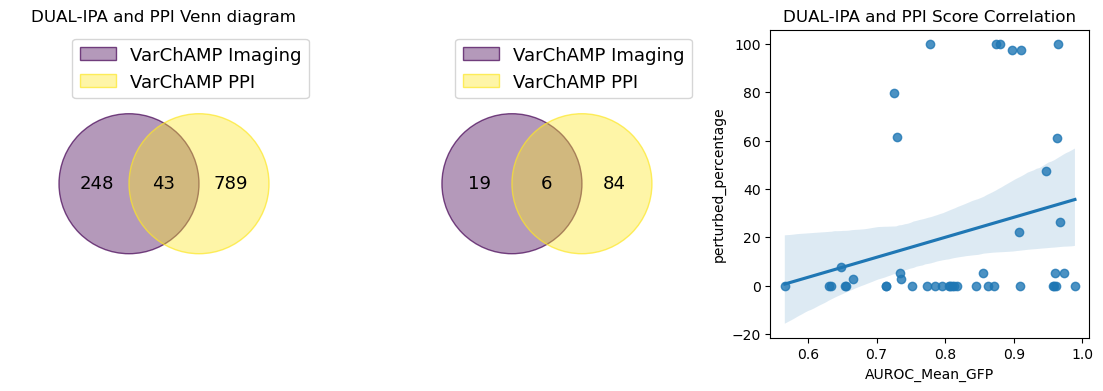

In [15]:
## merge the two assays by gene_variant
overlap_col = [c for c in img_sum_df.columns if c in ppi_sum_df.columns]
img_ppi_df = img_sum_df.select(["Gene", "gene_allele", "clinvar_clnsig_clean", "AUROC_Mean_GFP", "Altered_95th_perc_both_batches_GFP"]).join(
    ppi_sum_df.select(["Gene", "gene_allele", "clinvar_clnsig_clean", "perturbed_percentage", "ppi_perturbed_llr"]),
    on=["Gene","gene_allele", "clinvar_clnsig_clean"],
    how="full",
    coalesce=True,
    # suffix="_ppi"
)

img_ppi_set = {
    'VarChAMP Imaging': set(img_sum_df["gene_allele"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique())
}
fig, axes = plt.subplots(1,3,figsize=(14,4))
venn(img_ppi_set, ax=axes[0])
venn({
    'VarChAMP Imaging': set(img_sum_df["Gene"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["Gene"].unique())
}, ax=axes[1])

sns.regplot(data=img_ppi_df.to_pandas(),
            x="AUROC_Mean_GFP",
            y="perturbed_percentage",
           ax=axes[2])
axes[0].set_title("DUAL-IPA and PPI Venn diagram")
axes[2].set_title("DUAL-IPA and PPI Score Correlation")
plt.show()

In [16]:
img_ppi_df.unique("Gene")

Gene,gene_allele,clinvar_clnsig_clean,AUROC_Mean_GFP,Altered_95th_perc_both_batches_GFP,perturbed_percentage,ppi_perturbed_llr
str,str,str,f64,bool,f64,bool
"""BRCA1""","""BRCA1_Val275Ile""","""2_Benign""",0.850453,false,null,null
"""MYD88""","""MYD88_Met27Thr""","""2_Benign""",null,null,0.0,false
"""HMBS""","""HMBS_Arg321His""","""3_Conflicting""",null,null,100.0,true
"""SDHD""","""SDHD_Gly106Val""","""1_Pathogenic""",0.784553,false,0.0,false
"""EZH2""","""EZH2_Arg684Cys""","""1_Pathogenic""",null,null,0.0,false
…,…,…,…,…,…,…
"""KLHL3""","""KLHL3_Cys164Phe""","""1_Pathogenic""",null,null,100.0,true
"""PKP2""","""PKP2_Ile377Thr""","""4_VUS""",null,null,33.33,false
"""EMD""","""EMD_Asp72Val""","""4_VUS""",null,null,13.33,false


### 1.3 PPI alleles

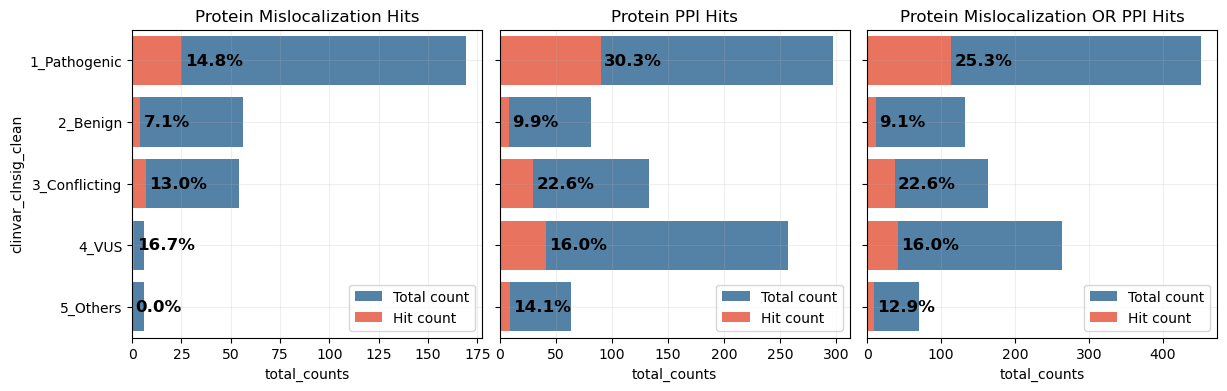

In [7]:
fig, axes = plt.subplots(1,3,figsize=(14,4),sharey=True)
plot_assay_hit_by_category(img_ppi_df.drop_nulls("Altered_95th_perc_both_batches_GFP"), "Altered_95th_perc_both_batches_GFP", "clinvar_clnsig_clean", f"Protein Mislocalization Hits", ax=axes[0])
plot_assay_hit_by_category(ppi_sum_df.drop_nulls("ppi_perturbed_llr"), "ppi_perturbed_llr", "clinvar_clnsig_clean", f"Protein PPI Hits", ax=axes[1])
plot_assay_hit_by_category(img_ppi_df.with_columns(
    (pl.col("Altered_95th_perc_both_batches_GFP").fill_null(False) | 
     pl.col("ppi_perturbed_llr").fill_null(False)).alias("Any_hit")
), "Any_hit", "clinvar_clnsig_clean", f"Protein Mislocalization OR PPI Hits", ax=axes[2])
plt.subplots_adjust(wspace=.05)
plt.show()

In [8]:
# with pl.Config(set_tbl_rows=30):
#     display(
#         img_ppi_df.filter(pl.col("Gene")=="RAD51D")["gene_allele","Altered_95th_perc_both_batches_GFP","AUROC_Mean_GFP","perturbed_percentage"].sort("AUROC_Mean_GFP", descending=True)
#     )

In [9]:
# img_dual_ppi_df.filter((pl.col("image_assayed"))&(pl.col("ppi_assayed"))).group_by("Gene").agg(
#     pl.col("Gene").len().alias("Count")
# )
# sns.scatterplot(data=img_dual_ppi_df.filter((pl.col("image_assayed"))&(pl.col("ppi_assayed"))).to_pandas(),
#                 x="AUROC_Mean_Morph",
#                 y="perturbed_percentage",
#                 style="Altered_95th_perc_Morph")

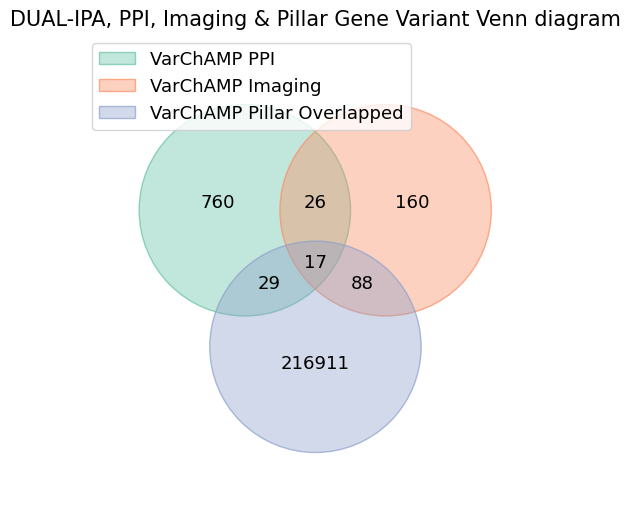

In [10]:
## Create the diagrams with your data
sets_data = {
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique()),
    'VarChAMP Imaging': set(img_sum_df["gene_variant"].unique()), 
    'VarChAMP Pillar Overlapped': set(pillar_clinvar_df["gene_variant"].unique()),
}

venn(sets_data, figsize=(6,8), legend_loc="upper left", cmap=sns.color_palette("Set2"))
plt.title("DUAL-IPA, PPI, Imaging & Pillar Gene Variant Venn diagram", fontsize=15, y=1.)
plt.show()

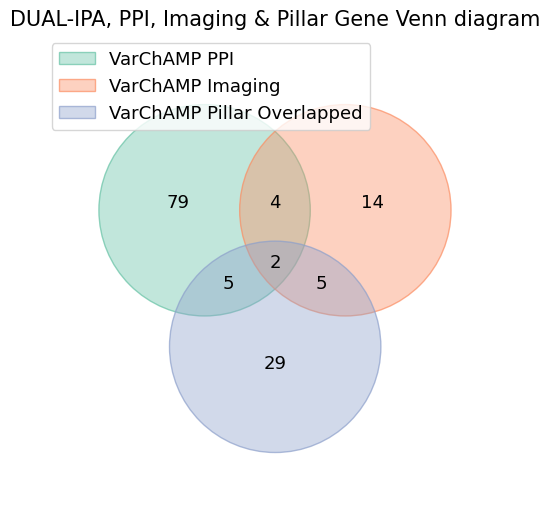

In [11]:
## Create the diagrams with your data
sets_data = {
    'VarChAMP PPI': set(ppi_sum_df["Gene"].unique()),
    'VarChAMP Imaging': set(img_sum_df["Gene"].unique()), 
    'VarChAMP Pillar Overlapped': set(pillar_clinvar_df["Gene"].unique()),
}

venn(sets_data, figsize=(6,8), legend_loc="upper left", cmap=sns.color_palette("Set2"))
plt.title("DUAL-IPA, PPI, Imaging & Pillar Gene Venn diagram", fontsize=15, y=1.)
plt.show()

In [20]:
img_ppi_df_in_pillar = img_ppi_df.filter(
   pl.col("gene_allele").is_in(pillar_clinvar_df["gene_variant"]),
).with_columns(
   pl.when(pl.col("Altered_95th_perc_both_batches_GFP").is_null())
   .then(0)
   .when(pl.col("Altered_95th_perc_both_batches_GFP"))
   .then(1)
   .otherwise(-1)
   .alias("Imaging"),
   pl.when(pl.col("ppi_perturbed_llr").is_null())
   .then(0)
   .when(pl.col("ppi_perturbed_llr"))
   .then(1)
   .otherwise(-1)
   .alias("PPI"),
).select(
   "Gene", "gene_allele", "Imaging", "PPI", "clinvar_clnsig_clean", "AUROC_Mean_GFP", "perturbed_percentage"
).sort("gene_allele")

df_pandas = img_ppi_df_in_pillar.to_pandas()

df_pandas = df_pandas.set_index('gene_allele')

In [28]:
img_ppi_df_in_pillar.group_by("Gene").agg(pl.len()).sort("len", descending=True)

Gene,len
str,u32
"""F9""",52
"""RAD51D""",20
"""HMBS""",16
"""BRCA1""",12
"""BAP1""",11
…,…
"""CTCF""",4
"""VHL""",4
"""G6PD""",4


In [53]:
for gene in img_ppi_df_in_pillar.group_by("Gene").agg(pl.len()).sort("len", descending=False)["Gene"]:
    img_ppi_gene_df = img_ppi_df_in_pillar.filter(
        pl.col("Gene")==gene
    )
    # display(img_ppi_gene_df)
    gene_var_pillar = pillar_clinvar_df.filter(
        pl.col("gene_variant").is_in(img_ppi_df_in_pillar["gene_allele"].unique()),
        pl.col("Gene")==gene
    )
    ## original dataset
    print(gene, gene_var_pillar.unique("Dataset")["Dataset"])
    display(gene_var_pillar)
    gene_var_pillar = gene_var_pillar.with_columns([
       pl.col('hgvs_c').str.contains(r'^c\.\d+[ATCG]>[ATCG]$').fill_null(False).alias('is_single_nt'),
       (pl.col('simplified_consequence') == 'missense_variant').alias('is_missense'),
       pl.len().over('gene_variant').alias('dup_count')
    ]).filter(
       (pl.col('dup_count') == 1) |
       ((pl.col('dup_count') > 1) & pl.col('is_single_nt') & pl.col('is_missense'))
    ).drop(['is_single_nt', 'is_missense', 'dup_count'])
    gene_var_pillar = gene_var_pillar.select([
        col for col in gene_var_pillar.columns 
        if gene_var_pillar.select(pl.col(col).is_null().all()).item() is False
    ])
    display(gene_var_pillar)
    with pl.Config(set_tbl_cols=50):
        display(
            gene_var_pillar
        )
    display(img_ppi_gene_df)
    
    # print("Total readouts for variants")
    # print("Unique variants profiled")
    # print(gene_var_pillar.unique("gene_variant").shape)
    # break

TPK1 shape: (1,)
Series: 'Dataset' [str]
[
	"TPK1_Weile_2017"
]


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Combined LR (Odds for Causality)_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
889324,"""TPK1_Weile_2017_var185954""","""TPK1_Weile_2017""","""TPK1""",17358.0,"""7""",-1.0,null,1.44682944e8,1.44682946e8,"""GTT""","""ATG""",null,"""148-150""",null,null,"""50.0""","""N""","""H""","""c.148_150delinsCAT""","""p.Asn50His""","""missense_variant""","""1.47683904300009""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000001-d-1""","""ENST00000360057.7""","""NM_022445.4""","""yeast""","""Cell viability""",null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.44682944e8,"""TPK1_Asn50His"""
889325,"""TPK1_Weile_2017_var185954""","""TPK1_Weile_2017""","""TPK1""",17358.0,"""7""",-1.0,null,1.44682944e8,1.44682944e8,"""T""","""G""",null,"""150""",null,null,"""50.0""","""N""","""H""","""-""","""p.Asn50His""","""synonymous_variant""","""1.47683904300009""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000001-d-1""","""ENST00000360057.7""","""NM_022445.4""","""yeast""","""Cell viability""",null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.44682944e8,"""TPK1_Asn50His"""


shape: (0, 0)
┌┐
╞╡
└┘

shape: (0, 0)
┌┐
╞╡
└┘

Gene,gene_allele,Imaging,PPI,clinvar_clnsig_clean,AUROC_Mean_GFP,perturbed_percentage
str,str,i32,i32,str,f64,f64
"""TPK1""","""TPK1_Asn50His""",0,-1,"""1_Pathogenic""",null,0.0


RHO shape: (1,)
Series: 'Dataset' [str]
[
	"RHO_Wan_2019"
]


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Combined LR (Odds for Causality)_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
999325,"""RHO_Wan_2019_var220532""","""RHO_Wan_2019""","""RHO""",10012.0,"""3""",1.0,null,1.29529062e8,1.29529062e8,"""G""","""A""",null,"""329""","""G""","""A""","""110""","""C""","""Y""","""c.329G>A""","""p.Cys110Tyr""","""missense_variant""","""0.1827611768972291""",null,null,"""No""",null,"""Pathogenic""","""criteria provided, multiple su…","""Dec 19, 2020""","""nucleotide""","""urn:mavedb:00000099-a-1""","""ENST00000296271.4""","""NM_000539.3""","""immortalized human cells""","""Reporter""","""Fluorescence""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.29529062e8,"""RHO_Cys110Tyr"""
999338,"""RHO_Wan_2019_var220545""","""RHO_Wan_2019""","""RHO""",10012.0,"""3""",1.0,null,1.29530917e8,1.29530917e8,"""C""","""T""",null,"""403""","""C""","""T""","""135""","""R""","""W""","""c.403C>T""","""p.Arg135Trp""","""missense_variant""","""0.3086407787092269""",null,null,"""No""",0.000001,"""Pathogenic""","""criteria provided, multiple su…","""Jan 08, 2024""","""nucleotide""","""urn:mavedb:00000099-a-1""","""ENST00000296271.4""","""NM_000539.3""","""immortalized human cells""","""Reporter""","""Fluorescence""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.29530917e8,"""RHO_Arg135Trp"""
999387,"""RHO_Wan_2019_var220594""","""RHO_Wan_2019""","""RHO""",10012.0,"""3""",1.0,null,1.29532289e8,1.29532289e8,"""A""","""G""",null,"""569""","""A""","""G""","""190""","""D""","""G""","""c.569A>G""","""p.Asp190Gly""","""missense_variant""","""0.2641042882582283""",null,null,"""No""",null,"""Pathogenic/Likely pathogenic""","""criteria provided, multiple su…","""Oct 01, 2023""","""nucleotide""","""urn:mavedb:00000099-a-1""","""ENST00000296271.4""","""NM_000539.3""","""immortalized human cells""","""Reporter""","""Fluorescence""",…,null,null,null,null,null,null,null,null,null,nu

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,hg38_end,ref_allele,alt_allele,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,REVEL,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
999325,"""RHO_Wan_2019_var220532""","""RHO_Wan_2019""","""RHO""",10012.0,"""3""",1.0,1.29529062e8,1.29529062e8,"""G""","""A""","""329""","""G""","""A""","""110""","""C""","""Y""","""c.329G>A""","""p.Cys110Tyr""","""missense_variant""","""0.1827611768972291""","""No""",null,"""Pathogenic""","""criteria provided, multiple su…","""Dec 19, 2020""","""nucleotide""","""urn:mavedb:00000099-a-1""","""ENST00000296271.4""","""NM_000539.3""","""immortalized human cells""","""Reporter""","""Fluorescence""","""cell surface expression""","""No""","""missense_variant""",0.79,1.29529062e8,"""RHO_Cys110Tyr"""
999338,"""RHO_Wan_2019_var220545""","""RHO_Wan_2019""","""RHO""",10012.0,"""3""",1.0,1.29530917e8,1.29530917e8,"""C""","""T""","""403""","""C""","""T""","""135""","""R""","""W""","""c.403C>T""","""p.Arg135Trp""","""missense_variant""","""0.3086407787092269""","""No""",0.000001,"""Pathogenic""","""criteria provided, multiple su…","""Jan 08, 2024""","""nucleotide""","""urn:mavedb:00000099-a-1""","""ENST00000296271.4""","""NM_000539.3""","""immortalized human cells""","""Reporter""","""Fluorescence""","""cell surface expression""","""No""","""missense_variant""",0.931,1.29530917e8,"""RHO_Arg135Trp"""
999387,"""RHO_Wan_2019_var220594""","""RHO_Wan_2019""","""RHO""",10012.0,"""3""",1.0,1.29532289e8,1.29532289e8,"""A""","""G""","""569""","""A""","""G""","""190""","""D""","""G""","""c.569A>G""","""p.Asp190Gly""","""missense_variant""","""0.2641042882582283""","""No""",null,"""Pathogenic/Likely pathogenic""","""criteria provided, multiple su…","""Oct 01, 2023""","""nucleotide""","""urn:mavedb:00000099-a-1""","""ENST00000296271.4""","""NM_000539.3""","""immortalized human cells""","""Reporter""","""Fluorescence""","""cell surface expression""","""No""","""missense_variant""",0.664,1.29532289e8,"""RHO_Asp190Gly"""


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,hg38_end,ref_allele,alt_allele,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,REVEL,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
999325,"""RHO_Wan_2019_var220532""","""RHO_Wan_2019""","""RHO""",10012.0,"""3""",1.0,1.29529062e8,1.29529062e8,"""G""","""A""","""329""","""G""","""A""","""110""","""C""","""Y""","""c.329G>A""","""p.Cys110Tyr""","""missense_variant""","""0.1827611768972291""","""No""",null,"""Pathogenic""","""criteria provided, multiple su…","""Dec 19, 2020""","""nucleotide""","""urn:mavedb:00000099-a-1""","""ENST00000296271.4""","""NM_000539.3""","""immortalized human cells""","""Reporter""","""Fluorescence""","""cell surface expression""","""No""","""missense_variant""",0.79,1.29529062e8,"""RHO_Cys110Tyr"""
999338,"""RHO_Wan_2019_var220545""","""RHO_Wan_2019""","""RHO""",10012.0,"""3""",1.0,1.29530917e8,1.29530917e8,"""C""","""T""","""403""","""C""","""T""","""135""","""R""","""W""","""c.403C>T""","""p.Arg135Trp""","""missense_variant""","""0.3086407787092269""","""No""",0.000001,"""Pathogenic""","""criteria provided, multiple su…","""Jan 08, 2024""","""nucleotide""","""urn:mavedb:00000099-a-1""","""ENST00000296271.4""","""NM_000539.3""","""immortalized human cells""","""Reporter""","""Fluorescence""","""cell surface expression""","""No""","""missense_variant""",0.931,1.29530917e8,"""RHO_Arg135Trp"""
999387,"""RHO_Wan_2019_var220594""","""RHO_Wan_2019""","""RHO""",10012.0,"""3""",1.0,1.29532289e8,1.29532289e8,"""A""","""G""","""569""","""A""","""G""","""190""","""D""","""G""","""c.569A>G""","""p.Asp190Gly""","""missense_variant""","""0.2641042882582283""","""No""",null,"""Pathogenic/Likely pathogenic""","""criteria provided, multiple su…","""Oct 01, 2023""","""nucleotide""","""urn:mavedb:00000099-a-1""","""ENST00000296271.4""","""NM_000539.3""","""immortalized human cells""","""Reporter""","""Fluorescence""","""cell surface expression""","""No""","""missense_variant""",0.664,1.29532289e8,"""RHO_Asp190Gly"""


Gene,gene_allele,Imaging,PPI,clinvar_clnsig_clean,AUROC_Mean_GFP,perturbed_percentage
str,str,i32,i32,str,f64,f64
"""RHO""","""RHO_Arg135Trp""",1,0,"""1_Pathogenic""",0.999695,null
"""RHO""","""RHO_Asp190Gly""",1,0,"""1_Pathogenic""",0.999455,null
"""RHO""","""RHO_Cys110Tyr""",1,0,"""1_Pathogenic""",0.999551,null


VHL shape: (1,)
Series: 'Dataset' [str]
[
	"VHL_Buckley_2024"
]


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Combined LR (Odds for Causality)_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
929501,"""VHL_Buckley_2024_var101176""","""VHL_Buckley_2024""","""VHL""",12687.0,"""3""",1.0,null,1.0142001e7,null,"""G""","""A""","""ENST00000256474.3""","""154""","""G""","""A""","""52.0""","""E""","""K""","""c.154G>A""","""p.Glu52Lys""","""missense_variant""","""-0.0532046723704077""",null,"""Neutral""","""Yes""",0.000068,"""Benign""","""reviewed by expert panel""","""Jun 25, 2024""","""nucleotide""","""urn:mavedb:00000675-a-1""","""ENST00000256474.3""","""NM_000551.4""","""immortalized human cells""","""Cell Viability""","""Cell Survival""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""161402.0""","""CA020056""","""von Hippel-Lindau disease""","""MONDO:0008667""","""Autosomal dominant inheritance""","""Benign""","""BA1""","""PP3""","""The variant NM_000551.3(VHL):c…",null,"""VHL VCEP""","""https://cspec.clinicalgenome.o…","""6/25/24""","""6/25/24""","""False""","""https://erepo.genome.network/e…","""9f120c06-bb61-4115-9c9c-187ef4…","""VUS""","""BA1""",1.0142001e7,"""VHL_Glu52Lys"""
929661,"""VHL_Buckley_2024_var101336""","""VHL_Buckley_2024""","""VHL""",12687.0,"""3""",1.0,null,1.0142055e7,null,"""G""","""A""","""ENST00000256474.3""","""208""","""G""","""A""","""70.0""","""E""","""K""","""c.208G>A""","""p.Glu70Lys""","""missense_variant""","""-0.350052772546135""",null,"""Intermediate""","""Yes""",6.2254e-7,"""Pathogenic/Likely pathogenic""","""criteria provided, multiple su…","""Nov 08, 2023""","""nucleotide""","""urn:mavedb:00000675-a-1""","""ENST00000256474.3""","""NM_000551.4""","""immortalized human cells""","""Cell Viability""","""Cell Survival""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0142055e7,"""VHL_Glu70Lys"""
929756,"""VHL_Buckley_2024_var101431""","""VHL_Buckley_2024""","""VHL""",12687.0,"""3""",1.0,null,1.0142088e7,null,"""C""","""T""","""ENST00000256474.3""","""241""","""C""","""T""","""81.0""","""P""","""S""","""c.241C>T"

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,REVEL,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
929501,"""VHL_Buckley_2024_var101176""","""VHL_Buckley_2024""","""VHL""",12687.0,"""3""",1.0,1.0142001e7,"""G""","""A""","""ENST00000256474.3""","""154""","""G""","""A""","""52.0""","""E""","""K""","""c.154G>A""","""p.Glu52Lys""","""missense_variant""","""-0.0532046723704077""","""Neutral""","""Yes""",0.000068,"""Benign""","""reviewed by expert panel""","""Jun 25, 2024""","""nucleotide""","""urn:mavedb:00000675-a-1""","""ENST00000256474.3""","""NM_000551.4""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.559,"""161402.0""","""CA020056""","""von Hippel-Lindau disease""","""MONDO:0008667""","""Autosomal dominant inheritance""","""Benign""","""BA1""","""PP3""","""The variant NM_000551.3(VHL):c…","""VHL VCEP""","""https://cspec.clinicalgenome.o…","""6/25/24""","""6/25/24""","""False""","""https://erepo.genome.network/e…","""9f120c06-bb61-4115-9c9c-187ef4…","""VUS""","""BA1""",1.0142001e7,"""VHL_Glu52Lys"""
929661,"""VHL_Buckley_2024_var101336""","""VHL_Buckley_2024""","""VHL""",12687.0,"""3""",1.0,1.0142055e7,"""G""","""A""","""ENST00000256474.3""","""208""","""G""","""A""","""70.0""","""E""","""K""","""c.208G>A""","""p.Glu70Lys""","""missense_variant""","""-0.350052772546135""","""Intermediate""","""Yes""",6.2254e-7,"""Pathogenic/Likely pathogenic""","""criteria provided, multiple su…","""Nov 08, 2023""","""nucleotide""","""urn:mavedb:00000675-a-1""","""ENST00000256474.3""","""NM_000551.4""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.668,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0142055e7,"""VHL_Glu70Lys"""
929756,"""VHL_Buckley_2024_var101431""","""VHL_Buckley_2024""","""VHL""",12687.0,"""3""",1.0,1.0142088e7,"""C""","""T""","""ENST00000256474.3""","""241""","""C""","""T""","""81.0""","""P""","""S""","""c.241C>T""","""p.Pro81Ser""","""missense_variant""","""-0.0025152908280948""","""Neutral""","""Yes""",0.000353,"""Benign""","""reviewed by expert panel""","""Jun 25, 2024""","""nucleotide""","""urn:mavedb:00000675-a-1""","""ENST00000256474.3""","""NM_000551.4""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.678,"""2233.0""","""CA020148""","""von Hippel-Lindau disease""","""MONDO:0008667""","""Autosomal dominant inheritance""","""Benign""","""BA1""",null,"""The variant NM_000551.4(VHL):c…","""VHL VCEP""","""https://cspec.clinicalgenome.o…","""6/25/24""","""6/25/24""","""False""","""https://erepo.genome.network/e…","""416afbe6-3dd6-40d9-9e61-d3c54b…","""VUS""","""BA1""",1.014

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,…,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,REVEL,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,…,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
929501,"""VHL_Buckley_2024_var101176""","""VHL_Buckley_2024""","""VHL""",12687.0,"""3""",1.0,1.0142001e7,"""G""","""A""","""ENST00000256474.3""","""154""","""G""","""A""","""52.0""","""E""","""K""","""c.154G>A""","""p.Glu52Lys""","""missense_variant""","""-0.0532046723704077""","""Neutral""","""Yes""",0.000068,"""Benign""",…,"""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.559,"""161402.0""","""CA020056""","""von Hippel-Lindau disease""","""MONDO:0008667""","""Autosomal dominant inheritance""","""Benign""","""BA1""","""PP3""","""The variant NM_000551.3(VHL):c…","""VHL VCEP""","""https://cspec.clinicalgenome.o…","""6/25/24""","""6/25/24""","""False""","""https://erepo.genome.network/e…","""9f120c06-bb61-4115-9c9c-187ef4…","""VUS""","""BA1""",1.0142001e7,"""VHL_Glu52Lys"""
929661,"""VHL_Buckley_2024_var101336""","""VHL_Buckley_2024""","""VHL""",12687.0,"""3""",1.0,1.0142055e7,"""G""","""A""","""ENST00000256474.3""","""208""","""G""","""A""","""70.0""","""E""","""K""","""c.208G>A""","""p.Glu70Lys""","""missense_variant""","""-0.350052772546135""","""Intermediate""","""Yes""",6.2254e-7,"""Pathogenic/Likely pathogenic""",…,"""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.668,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0142055e7,"""VHL_Glu70Lys"""
929756,"""VHL_Buckley_2024_var101431""","""VHL_Buckley_2024""","""VHL""",12687.0,"""3""",1.0,1.0142088e7,"""C""","""T""","""ENST00000256474.3""","""241""","""C""","""T""","""81.0""","""P""","""S""","""c.241C>T""","""p.Pro81Ser""","""missense_variant""","""-0.0025152908280948""","""Neutral""","""Yes""",0.000353,"""Benign""",…,"""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.678,"""2233.0""","""CA020148""","""von Hippel-Lindau disease""","""MONDO:0008667""","""Autosomal dominant inheritance""","""Benign""","""BA1""",null,"""The variant NM_000551.4(VHL):c…","""VHL VCEP""","""https://cspec.clinicalgenome.o…","""6/25/24""","""6/25/24""","""False""","""https://erepo.genome.network/e…","""416afbe6-3dd6-40d9-9e61-d3c54b…","""VUS""","""BA1""",1.0142088e7,"""VHL_Pro81Ser"""
930027,"""VHL_Buckley_2024_var101702""","""VHL_Buckley_2024""","""VHL""",12687.0,"""3""",1.0,1.0142181e7,"""T""","""C""","""ENST00000256474.3""","""334""","""T""","""C""","""112.0""","""Y""","""H""","""c.334T>C""","""p.Tyr112His""","""missense_variant""","""-0.789074004711427""","""LOF2""","""Yes""",null,"""Pathogenic""",…,"""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.851,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0142181e7,"""VHL_Tyr112His"""


Gene,gene_allele,Imaging,PPI,clinvar_clnsig_clean,AUROC_Mean_GFP,perturbed_percentage
str,str,i32,i32,str,f64,f64
"""VHL""","""VHL_Glu52Lys""",0,-1,"""2_Benign""",null,0.0
"""VHL""","""VHL_Glu70Lys""",0,-1,"""1_Pathogenic""",null,0.0
"""VHL""","""VHL_Pro81Ser""",0,1,"""2_Benign""",null,100.0
"""VHL""","""VHL_Tyr112His""",0,1,"""1_Pathogenic""",null,100.0


CTCF shape: (1,)
Series: 'Dataset' [str]
[
	"CTCF_unpublished"
]


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Combined LR (Odds for Causality)_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
964317,"""CTCF_unpublished_var158564""","""CTCF_unpublished""","""CTCF""",13723.0,"""16""",1.0,null,6.7616816e7,6.7616816e7,"""C""","""G""",null,"""1024""","""C""","""G""","""342""","""R""","""G""","""c.1024C>G""","""p.Arg342Gly""","""missense_variant""","""0.0775292""",null,"""functionally_normal""","""Yes""",null,"""Likely pathogenic""","""criteria provided, single subm…","""Feb 01, 2021""","""nucleotide""",null,"""ENST00000264010.10""","""NM_006565.4""","""immortalized human cells""","""Cell viability""","""Cell survival""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,6.7616816e7,"""CTCF_Arg342Gly"""
964318,"""CTCF_unpublished_var158565""","""CTCF_unpublished""","""CTCF""",13723.0,"""16""",1.0,null,6.7616816e7,6.7616816e7,"""C""","""T""",null,"""1024""","""C""","""T""","""342""","""R""","""C""","""c.1024C>T""","""p.Arg342Cys""","""missense_variant""","""0.0968285""",null,"""functionally_normal""","""Yes""",6.1953e-7,"""Pathogenic/Likely pathogenic""","""criteria provided, multiple su…","""Aug 31, 2022""","""nucleotide""",null,"""ENST00000264010.10""","""NM_006565.4""","""immortalized human cells""","""Cell viability""","""Cell survival""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,6.7616816e7,"""CTCF_Arg342Cys"""
965455,"""CTCF_unpublished_var159702""","""CTCF_unpublished""","""CTCF""",13723.0,"""16""",1.0,null,6.7621454e7,6.7621454e7,"""A""","""G""",null,"""1220""","""A""","""G""","""407""","""Y""","""C""","""c.1220A>G""","""p.Tyr407Cys""","""missense_variant""","""0.00170449""",null,"""functionally_normal""","""Yes""",null,"""Likely pathogenic""","""criteria provided, single subm…","""Jan 12, 2016""","""nucleotide""",null,"""ENST00000264010.10""","""NM_006565.4""","""immortalized human cells""","""Cell viability""","""Cell survival""",…,null,null,nul

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,hg38_end,ref_allele,alt_allele,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,REVEL,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
964317,"""CTCF_unpublished_var158564""","""CTCF_unpublished""","""CTCF""",13723.0,"""16""",1.0,6.7616816e7,6.7616816e7,"""C""","""G""","""1024""","""C""","""G""","""342""","""R""","""G""","""c.1024C>G""","""p.Arg342Gly""","""missense_variant""","""0.0775292""","""functionally_normal""","""Yes""",null,"""Likely pathogenic""","""criteria provided, single subm…","""Feb 01, 2021""","""nucleotide""","""ENST00000264010.10""","""NM_006565.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.62,6.7616816e7,"""CTCF_Arg342Gly"""
964318,"""CTCF_unpublished_var158565""","""CTCF_unpublished""","""CTCF""",13723.0,"""16""",1.0,6.7616816e7,6.7616816e7,"""C""","""T""","""1024""","""C""","""T""","""342""","""R""","""C""","""c.1024C>T""","""p.Arg342Cys""","""missense_variant""","""0.0968285""","""functionally_normal""","""Yes""",6.1953e-7,"""Pathogenic/Likely pathogenic""","""criteria provided, multiple su…","""Aug 31, 2022""","""nucleotide""","""ENST00000264010.10""","""NM_006565.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.559,6.7616816e7,"""CTCF_Arg342Cys"""
965455,"""CTCF_unpublished_var159702""","""CTCF_unpublished""","""CTCF""",13723.0,"""16""",1.0,6.7621454e7,6.7621454e7,"""A""","""G""","""1220""","""A""","""G""","""407""","""Y""","""C""","""c.1220A>G""","""p.Tyr407Cys""","""missense_variant""","""0.00170449""","""functionally_normal""","""Yes""",null,"""Likely pathogenic""","""criteria provided, single subm…","""Jan 12, 2016""","""nucleotide""","""ENST00000264010.10""","""NM_006565.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.51,6.7621454e7,"""CTCF_Tyr407Cys"""
965999,"""CTCF_unpublished_var160246""","""CTCF_unpublished""","""CTCF""",13723.0,"""16""",1.0,6.7626562e7,6.7626562e7,"""C""","""A""","""1365""","""C""","""A""","""455""","""H""","""Q""","""c.1365C>A""","""p.His455Gln""","""missense_variant""","""-0.32254""","""functionally_abnormal""","""Yes""",0.000001,null,null,null,"""nucleotide""","""ENST00000264010.10""","""NM_006565.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.579,6.7626562e7,"""CTCF_His455Gln"""
966000,"""CTCF_unpublished_var160247""","""CTCF_unpublished""","""CTCF""",13723.0,"""16""",1.0,6.7626562e7,6.7626562e7,"""C""","""G""","""1365""","""C""","""G""","""455""","""H""","""Q""","""c.1365C>G""","""p.His455Gln""","""missense_variant""","""-0.295056""","""functionally_abnormal""","""Yes""",null,"""Likely pathogenic""","""criteria provided, single subm…","""Jun 10, 2019""","""nucleotide""","""ENST00000264010.10""","""NM_006565.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.579,6.7626562e7,"""CTCF_His455Gln"""


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,hg38_end,ref_allele,alt_allele,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,REVEL,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
964317,"""CTCF_unpublished_var158564""","""CTCF_unpublished""","""CTCF""",13723.0,"""16""",1.0,6.7616816e7,6.7616816e7,"""C""","""G""","""1024""","""C""","""G""","""342""","""R""","""G""","""c.1024C>G""","""p.Arg342Gly""","""missense_variant""","""0.0775292""","""functionally_normal""","""Yes""",null,"""Likely pathogenic""","""criteria provided, single subm…","""Feb 01, 2021""","""nucleotide""","""ENST00000264010.10""","""NM_006565.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.62,6.7616816e7,"""CTCF_Arg342Gly"""
964318,"""CTCF_unpublished_var158565""","""CTCF_unpublished""","""CTCF""",13723.0,"""16""",1.0,6.7616816e7,6.7616816e7,"""C""","""T""","""1024""","""C""","""T""","""342""","""R""","""C""","""c.1024C>T""","""p.Arg342Cys""","""missense_variant""","""0.0968285""","""functionally_normal""","""Yes""",6.1953e-7,"""Pathogenic/Likely pathogenic""","""criteria provided, multiple su…","""Aug 31, 2022""","""nucleotide""","""ENST00000264010.10""","""NM_006565.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.559,6.7616816e7,"""CTCF_Arg342Cys"""
965455,"""CTCF_unpublished_var159702""","""CTCF_unpublished""","""CTCF""",13723.0,"""16""",1.0,6.7621454e7,6.7621454e7,"""A""","""G""","""1220""","""A""","""G""","""407""","""Y""","""C""","""c.1220A>G""","""p.Tyr407Cys""","""missense_variant""","""0.00170449""","""functionally_normal""","""Yes""",null,"""Likely pathogenic""","""criteria provided, single subm…","""Jan 12, 2016""","""nucleotide""","""ENST00000264010.10""","""NM_006565.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.51,6.7621454e7,"""CTCF_Tyr407Cys"""
965999,"""CTCF_unpublished_var160246""","""CTCF_unpublished""","""CTCF""",13723.0,"""16""",1.0,6.7626562e7,6.7626562e7,"""C""","""A""","""1365""","""C""","""A""","""455""","""H""","""Q""","""c.1365C>A""","""p.His455Gln""","""missense_variant""","""-0.32254""","""functionally_abnormal""","""Yes""",0.000001,null,null,null,"""nucleotide""","""ENST00000264010.10""","""NM_006565.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.579,6.7626562e7,"""CTCF_His455Gln"""
966000,"""CTCF_unpublished_var160247""","""CTCF_unpublished""","""CTCF""",13723.0,"""16""",1.0,6.7626562e7,6.7626562e7,"""C""","""G""","""1365""","""C""","""G""","""455""","""H""","""Q""","""c.1365C>G""","""p.His455Gln""","""missense_variant""","""-0.295056""","""functionally_abnormal""","""Yes""",null,"""Likely pathogenic""","""criteria provided, single subm…","""Jun 10, 2019""","""nucleotide""","""ENST00000264010.10""","""NM_006565.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.579,6.7626562e7,"""CTCF_His455Gln"""


Gene,gene_allele,Imaging,PPI,clinvar_clnsig_clean,AUROC_Mean_GFP,perturbed_percentage
str,str,i32,i32,str,f64,f64
"""CTCF""","""CTCF_Arg342Cys""",-1,-1,"""1_Pathogenic""",0.713834,0.0
"""CTCF""","""CTCF_Arg342Gly""",-1,0,"""1_Pathogenic""",0.928248,null
"""CTCF""","""CTCF_His455Gln""",-1,-1,"""1_Pathogenic""",0.813141,0.0
"""CTCF""","""CTCF_Tyr407Cys""",-1,-1,"""1_Pathogenic""",0.653493,0.0


G6PD shape: (1,)
Series: 'Dataset' [str]
[
	"G6PD_unpublished"
]


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Combined LR (Odds for Causality)_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
266792,"""G6PD_unpublished_var120697""","""G6PD_unpublished""","""G6PD""",4057.0,"""X""",-1.0,null,1.5453266e8,1.54532662e8,"""CTC""","""TTT""",null,"""1192-1194""",null,null,"""398""","""E""","""K""","""c.1192_1194delinsAAA""","""p.Glu398Lys""","""missense_variant""","""1.169536965861414""","""1.324362799436374;1.0993208026…",null,"""No""",null,null,null,null,"""aa""",null,"""ENST00000393562.10""","""NM_001360016.2""","""immortalized human cells""","""Reporter""","""Fluorescence""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.5453266e8,"""G6PD_Glu398Lys"""
266793,"""G6PD_unpublished_var120697""","""G6PD_unpublished""","""G6PD""",4057.0,"""X""",-1.0,null,1.5453266e8,1.5453266e8,"""C""","""T""",null,"""1194""",null,null,"""398""","""E""","""K""","""c.1194G>A""","""p.Glu398Lys""","""synonymous_variant""","""1.169536965861414""","""1.324362799436374;1.0993208026…",null,"""No""",0.000007,null,null,null,"""aa""",null,"""ENST00000393562.10""","""NM_001360016.2""","""immortalized human cells""","""Reporter""","""Fluorescence""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.5453266e8,"""G6PD_Glu398Lys"""
271022,"""G6PD_unpublished_var122084""","""G6PD_unpublished""","""G6PD""",4057.0,"""X""",-1.0,null,1.5453272e8,1.54532722e8,"""GCC""","""AGA""",null,"""1132-1134""",null,null,"""378""","""G""","""S""","""c.1132_1134delinsTCT""","""p.Gly378Ser""","""missense_variant""","""1.025359089784005""","""1.524249268852023;0.3717442964…",null,"""No""",null,null,null,null,"""aa""",null,"""ENST00000393562.10""","""NM_001360016.2""","""immortalized human cells""","""Reporter""","""Fluorescence""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.545

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,hg38_end,ref_allele,alt_allele,transcript_pos,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,REVEL,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
271023,"""G6PD_unpublished_var122084""","""G6PD_unpublished""","""G6PD""",4057.0,"""X""",-1.0,1.5453272e8,1.54532721e8,"""CC""","""GA""","""1133-1134""","""378""","""G""","""S""","""c.1133G>T""","""p.Gly378Ser""","""missense_variant""","""1.025359089784005""","""1.524249268852023;0.3717442964…","""No""",null,null,null,null,"""aa""","""ENST00000393562.10""","""NM_001360016.2""","""immortalized human cells""","""Reporter""","""Fluorescence""","""Protein stability""","""Yes""","""missense_variant""",null,1.5453272e8,"""G6PD_Gly378Ser"""
274224,"""G6PD_unpublished_var123133""","""G6PD_unpublished""","""G6PD""",4057.0,"""X""",-1.0,1.54536156e8,1.54536157e8,"""GA""","""AG""","""142-143""","""48""","""I""","""T""","""c.142A>C""","""p.Ile48Thr""","""missense_variant""","""0.3329082933240921""","""0.6796720223346846;-0.34411752…","""No""",null,null,null,null,"""aa""","""ENST00000393562.10""","""NM_001360016.2""","""immortalized human cells""","""Reporter""","""Fluorescence""","""Protein stability""","""Yes""","""missense_variant""",null,1.54536156e8,"""G6PD_Ile48Thr"""
274225,"""G6PD_unpublished_var123133""","""G6PD_unpublished""","""G6PD""",4057.0,"""X""",-1.0,1.54536156e8,1.54536156e8,"""A""","""G""","""143""","""48""","""I""","""T""","""c.143T>C""","""p.Ile48Thr""","""missense_variant""","""0.3329082933240921""","""0.6796720223346846;-0.34411752…","""No""",0.000014,"""Pathogenic/Likely pathogenic""","""criteria provided, multiple su…","""Aug 31, 2024""","""aa""","""ENST00000393562.10""","""NM_001360016.2""","""immortalized human cells""","""Reporter""","""Fluorescence""","""Protein stability""","""Yes""","""missense_variant""",0.8,1.54536156e8,"""G6PD_Ile48Thr"""
285730,"""G6PD_unpublished_var126900""","""G6PD_unpublished""","""G6PD""",4057.0,"""X""",-1.0,1.5453276e8,1.5453276e8,"""C""","""T""","""1094""","""365.0""","""R""","""H""","""c.1094G>A""","""p.Arg365His""","""missense_variant""","""0.95310181152785""","""0.993865394126386;0.8982217968…","""No""",8.2618e-7,"""Likely pathogenic""","""criteria provided, single subm…","""Aug 12, 2022""","""aa""","""ENST00000393562.10""","""NM_001360016.2""","""immortalized human cells""","""Reporter""","""Fluorescence""","""Protein stability""","""Yes""","""missense_variant""",0.798,1.5453276e8,"""G6PD_Arg365His"""


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,hg38_end,ref_allele,alt_allele,transcript_pos,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,REVEL,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
271023,"""G6PD_unpublished_var122084""","""G6PD_unpublished""","""G6PD""",4057.0,"""X""",-1.0,1.5453272e8,1.54532721e8,"""CC""","""GA""","""1133-1134""","""378""","""G""","""S""","""c.1133G>T""","""p.Gly378Ser""","""missense_variant""","""1.025359089784005""","""1.524249268852023;0.3717442964…","""No""",null,null,null,null,"""aa""","""ENST00000393562.10""","""NM_001360016.2""","""immortalized human cells""","""Reporter""","""Fluorescence""","""Protein stability""","""Yes""","""missense_variant""",null,1.5453272e8,"""G6PD_Gly378Ser"""
274224,"""G6PD_unpublished_var123133""","""G6PD_unpublished""","""G6PD""",4057.0,"""X""",-1.0,1.54536156e8,1.54536157e8,"""GA""","""AG""","""142-143""","""48""","""I""","""T""","""c.142A>C""","""p.Ile48Thr""","""missense_variant""","""0.3329082933240921""","""0.6796720223346846;-0.34411752…","""No""",null,null,null,null,"""aa""","""ENST00000393562.10""","""NM_001360016.2""","""immortalized human cells""","""Reporter""","""Fluorescence""","""Protein stability""","""Yes""","""missense_variant""",null,1.54536156e8,"""G6PD_Ile48Thr"""
274225,"""G6PD_unpublished_var123133""","""G6PD_unpublished""","""G6PD""",4057.0,"""X""",-1.0,1.54536156e8,1.54536156e8,"""A""","""G""","""143""","""48""","""I""","""T""","""c.143T>C""","""p.Ile48Thr""","""missense_variant""","""0.3329082933240921""","""0.6796720223346846;-0.34411752…","""No""",0.000014,"""Pathogenic/Likely pathogenic""","""criteria provided, multiple su…","""Aug 31, 2024""","""aa""","""ENST00000393562.10""","""NM_001360016.2""","""immortalized human cells""","""Reporter""","""Fluorescence""","""Protein stability""","""Yes""","""missense_variant""",0.8,1.54536156e8,"""G6PD_Ile48Thr"""
285730,"""G6PD_unpublished_var126900""","""G6PD_unpublished""","""G6PD""",4057.0,"""X""",-1.0,1.5453276e8,1.5453276e8,"""C""","""T""","""1094""","""365.0""","""R""","""H""","""c.1094G>A""","""p.Arg365His""","""missense_variant""","""0.95310181152785""","""0.993865394126386;0.8982217968…","""No""",8.2618e-7,"""Likely pathogenic""","""criteria provided, single subm…","""Aug 12, 2022""","""aa""","""ENST00000393562.10""","""NM_001360016.2""","""immortalized human cells""","""Reporter""","""Fluorescence""","""Protein stability""","""Yes""","""missense_variant""",0.798,1.5453276e8,"""G6PD_Arg365His"""


Gene,gene_allele,Imaging,PPI,clinvar_clnsig_clean,AUROC_Mean_GFP,perturbed_percentage
str,str,i32,i32,str,f64,f64
"""G6PD""","""G6PD_Arg365His""",-1,0,"""1_Pathogenic""",0.590062,null
"""G6PD""","""G6PD_Glu398Lys""",-1,0,"""1_Pathogenic""",0.657934,null
"""G6PD""","""G6PD_Gly378Ser""",-1,0,"""3_Conflicting""",0.696318,null
"""G6PD""","""G6PD_Ile48Thr""",-1,0,"""1_Pathogenic""",0.896083,null


GCK shape: (2,)
Series: 'Dataset' [str]
[
	"GCK_Gersing_2024_abundance"
	"GCK_Gersing_2023_complementati…
]


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Combined LR (Odds for Causality)_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
294904,"""GCK_Gersing_2023_complementati…","""GCK_Gersing_2023_complementati…","""GCK""",4195.0,"""7""",-1.0,null,4.414559e7,4.4145591e7,"""CG""","""TT""",null,"""1159-1160""",null,null,"""387.0""","""A""","""E""","""c.1159_1160delinsAA""","""p.Ala387Glu""","""missense_variant""","""0.0350375557645431""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000096-a-1""","""ENST00000403799.8""","""NM_000162.5""","""yeast""","""Cell viability""","""Cell Survival""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.414559e7,"""GCK_Ala387Glu"""
294905,"""GCK_Gersing_2023_complementati…","""GCK_Gersing_2023_complementati…","""GCK""",4195.0,"""7""",-1.0,null,4.414559e7,4.414559e7,"""G""","""T""",null,"""1160""",null,null,"""387.0""","""A""","""E""","""c.1160C>A""","""p.Ala387Glu""","""missense_variant""","""0.0350375557645431""",null,null,"""No""",6.2320e-7,"""Likely pathogenic""","""reviewed by expert panel""","""Feb 28, 2024""","""aa""","""urn:mavedb:00000096-a-1""","""ENST00000403799.8""","""NM_000162.5""","""yeast""","""Cell viability""","""Cell Survival""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""36181.0""","""CA213725""","""monogenic diabetes""","""MONDO:0015967""","""Semidominant inheritance""","""Likely Pathogenic""","""PM2_Supporting,PM5_Strong,PP2,…","""PS4,PM1""","""The c.1160C>A variant in the g…",null,"""Monogenic Diabetes VCEP""","""https://cspec.clinicalgenome.o…","""2/28/24""","""2/28/24""","""False""","""https://erepo.genome.network/e…","""6d8941fd-d5e3-465b-9e80-eceefd…","""VUS""","""PM2_Supporting,PM5_Strong,PP2""",4.414559e7,"""GCK_Ala387Glu"""
295887,"""GCK_Gersing_2023_complementati…","""GCK_Gersing_2023_complementati…","""GCK""",4195.0,"""7""",-1.0,null,4.4146573e7,4.4146573e7,"""G""","""A""",null,"""909""",null,null,"""303.0""","""R""","""W""","""c.909G>T""","""p.Arg303Trp""","""synonymous_variant""","""0.145534620576

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,REVEL,Interval 1 name,Interval 1 range,Interval 1 MaveDB class,Interval 2 name,Interval 2 range,Interval 2 MaveDB class,Interval 3 name,Interval 3 range,Interval 3 MaveDB class,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
294905,"""GCK_Gersing_2023_complementati…","""GCK_Gersing_2023_complementati…","""GCK""",4195.0,"""7""",-1.0,4.414559e7,4.414559e7,"""G""","""T""",null,"""1160""","""387.0""","""A""","""E""","""c.1160C>A""","""p.Ala387Glu""","""missense_variant""","""0.0350375557645431""","""No""",6.2320e-7,"""Likely pathogenic""","""reviewed by expert panel""","""Feb 28, 2024""","""aa""","""urn:mavedb:00000096-a-1""","""ENST00000403799.8""","""NM_000162.5""","""yeast""","""Cell viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.958,"""Decreased activity""","""(-Inf, 0.66)""","""Abnormal""","""Hyperactive""","""(1.18, Inf)""","""Not specified""","""Synonymous""","""(0.66,1.18)""","""Abnormal""","""36181.0""","""CA213725""","""monogenic diabetes""","""MONDO:0015967""","""Semidominant inheritance""","""Likely Pathogenic""","""PM2_Supporting,PM5_Strong,PP2,…","""PS4,PM1""","""The c.1160C>A variant in the g…","""Monogenic Diabetes VCEP""","""https://cspec.clinicalgenome.o…","""2/28/24""","""2/28/24""","""False""","""https://erepo.genome.network/e…","""6d8941fd-d5e3-465b-9e80-eceefd…","""VUS""","""PM2_Supporting,PM5_Strong,PP2""",4.414559e7,"""GCK_Ala387Glu"""
323747,"""GCK_Gersing_2024_abundance_var…","""GCK_Gersing_2024_abundance""","""GCK""",4195.0,"""7""",-1.0,4.414559e7,4.414559e7,"""G""","""T""","""ENST00000403799.8""","""1160""","""387.0""","""A""","""E""","""c.1160C>A""","""p.Ala387Glu""","""missense_variant""","""-0.106697788432006""","""No""",6.2320e-7,"""Likely pathogenic""","""reviewed by expert panel""","""Feb 28, 2024""","""aa""","""urn:mavedb:00000096-b-1""","""ENST00000403799.8""","""NM_000162.5""","""yeast""",null,"""Cell Survival""","""Abundance""","""No""","""missense_variant""",0.958,"""Low abundance ""","""(-Inf, 0.58)""","""Abnormal""",null,null,null,null,null,null,"""36181.0""","""CA213725""","""monogenic diabetes""","""MONDO:0015967""","""Semidominant inheritance""","""Likely Pathogenic""","""PM2_Supporting,PM5_Strong,PP2,…","""PS4,PM1""","""The c.1160C>A variant in the g…","""Monogenic Diabetes VCEP""","""https://cspec.clinicalgenome.o…","""2/28/24""","""2/28/24""","""False""","""https://erepo.genome.network/e…","""6d8941fd-d5e3-465b-9e80-eceefd…","""VUS""","""PM2_Supporting,PM5_Strong,PP2""",4.414559e7,"""GCK_Ala387Glu"""


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,…,Interval 2 range,Interval 2 MaveDB class,Interval 3 name,Interval 3 range,Interval 3 MaveDB class,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
294905,"""GCK_Gersing_2023_complementati…","""GCK_Gersing_2023_complementati…","""GCK""",4195.0,"""7""",-1.0,4.414559e7,4.414559e7,"""G""","""T""",null,"""1160""","""387.0""","""A""","""E""","""c.1160C>A""","""p.Ala387Glu""","""missense_variant""","""0.0350375557645431""","""No""",6.2320e-7,"""Likely pathogenic""","""reviewed by expert panel""","""Feb 28, 2024""",…,"""(1.18, Inf)""","""Not specified""","""Synonymous""","""(0.66,1.18)""","""Abnormal""","""36181.0""","""CA213725""","""monogenic diabetes""","""MONDO:0015967""","""Semidominant inheritance""","""Likely Pathogenic""","""PM2_Supporting,PM5_Strong,PP2,…","""PS4,PM1""","""The c.1160C>A variant in the g…","""Monogenic Diabetes VCEP""","""https://cspec.clinicalgenome.o…","""2/28/24""","""2/28/24""","""False""","""https://erepo.genome.network/e…","""6d8941fd-d5e3-465b-9e80-eceefd…","""VUS""","""PM2_Supporting,PM5_Strong,PP2""",4.414559e7,"""GCK_Ala387Glu"""
323747,"""GCK_Gersing_2024_abundance_var…","""GCK_Gersing_2024_abundance""","""GCK""",4195.0,"""7""",-1.0,4.414559e7,4.414559e7,"""G""","""T""","""ENST00000403799.8""","""1160""","""387.0""","""A""","""E""","""c.1160C>A""","""p.Ala387Glu""","""missense_variant""","""-0.106697788432006""","""No""",6.2320e-7,"""Likely pathogenic""","""reviewed by expert panel""","""Feb 28, 2024""",…,null,null,null,null,null,"""36181.0""","""CA213725""","""monogenic diabetes""","""MONDO:0015967""","""Semidominant inheritance""","""Likely Pathogenic""","""PM2_Supporting,PM5_Strong,PP2,…","""PS4,PM1""","""The c.1160C>A variant in the g…","""Monogenic Diabetes VCEP""","""https://cspec.clinicalgenome.o…","""2/28/24""","""2/28/24""","""False""","""https://erepo.genome.network/e…","""6d8941fd-d5e3-465b-9e80-eceefd…","""VUS""","""PM2_Supporting,PM5_Strong,PP2""",4.414559e7,"""GCK_Ala387Glu"""


Gene,gene_allele,Imaging,PPI,clinvar_clnsig_clean,AUROC_Mean_GFP,perturbed_percentage
str,str,i32,i32,str,f64,f64
"""GCK""","""GCK_Ala387Glu""",0,-1,"""1_Pathogenic""",null,50.0
"""GCK""","""GCK_Arg303Trp""",0,-1,"""1_Pathogenic""",null,50.0
"""GCK""","""GCK_Glu221Lys""",0,-1,"""1_Pathogenic""",null,50.0
"""GCK""","""GCK_Gly175Arg""",0,-1,"""1_Pathogenic""",null,0.0
"""GCK""","""GCK_Gly178Arg""",0,-1,"""5_Others""",null,0.0
"""GCK""","""GCK_Gly299Arg""",0,-1,"""1_Pathogenic""",null,50.0
"""GCK""","""GCK_Gly385Arg""",0,-1,"""1_Pathogenic""",null,50.0


BAP1 shape: (1,)
Series: 'Dataset' [str]
[
	"BAP1_Waters_2024"
]


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Combined LR (Odds for Causality)_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
968692,"""BAP1_Waters_2024_var162939""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",null,null,5.2409845e7,null,"""G""","""T""","""ENST00000460680.6""","""34""",null,null,"""12""","""P""","""T""","""c.34C>A""","""p.Pro12Thr""","""missense_variant""","""-0.137253385""",null,"""depleted""","""Yes""",null,"""Pathogenic""","""no assertion criteria provided""","""Feb 24, 2022""","""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""",null,"""immortalized human cells""","""Cell Viability""","""Cell Survival""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,5.2409845e7,"""BAP1_Pro12Thr"""
969130,"""BAP1_Waters_2024_var163377""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",null,null,5.2409585e7,null,"""C""","""T""","""ENST00000460680.6""","""91""",null,null,"""31""","""E""","""K""","""c.91G>A""","""p.Glu31Lys""","""missense_variant""","""-0.200824172""",null,"""depleted""","""Yes""",null,"""Conflicting classifications of…","""criteria provided, conflicting…","""Jan 21, 2024""","""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""",null,"""immortalized human cells""","""Cell Viability""","""Cell Survival""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,5.2409585e7,"""BAP1_Glu31Lys"""
969446,"""BAP1_Waters_2024_var163693""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",null,null,5.2408583e7,null,"""A""","""G""","""ENST00000460680.6""","""146""",null,null,"""49""","""L""","""P""","""c.146T>C""","""p.Leu49Pro""","""missense_variant""","""-0.134808835""",null,"""depleted""","""Yes""",null,"""Likely pathogenic""","""criteria provided, single subm…","""Sep 28, 2022""","""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""",null,"""immortalized human cells""","""Cell Viability""","""Cell Survival""",…,null,null,null,null,null,null,nul

,ID,Dataset,Gene,HGNC_id,Chrom,hg38_start,ref_allele,alt_allele,auth_transcript_id,transcript_pos,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,REVEL,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
968692,"""BAP1_Waters_2024_var162939""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",5.2409845e7,"""G""","""T""","""ENST00000460680.6""","""34""","""12""","""P""","""T""","""c.34C>A""","""p.Pro12Thr""","""missense_variant""","""-0.137253385""","""depleted""","""Yes""",null,"""Pathogenic""","""no assertion criteria provided""","""Feb 24, 2022""","""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.834,5.2409845e7,"""BAP1_Pro12Thr"""
969130,"""BAP1_Waters_2024_var163377""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",5.2409585e7,"""C""","""T""","""ENST00000460680.6""","""91""","""31""","""E""","""K""","""c.91G>A""","""p.Glu31Lys""","""missense_variant""","""-0.200824172""","""depleted""","""Yes""",null,"""Conflicting classifications of…","""criteria provided, conflicting…","""Jan 21, 2024""","""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.692,5.2409585e7,"""BAP1_Glu31Lys"""
969446,"""BAP1_Waters_2024_var163693""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",5.2408583e7,"""A""","""G""","""ENST00000460680.6""","""146""","""49""","""L""","""P""","""c.146T>C""","""p.Leu49Pro""","""missense_variant""","""-0.134808835""","""depleted""","""Yes""",null,"""Likely pathogenic""","""criteria provided, single subm…","""Sep 28, 2022""","""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.83,5.2408583e7,"""BAP1_Leu49Pro"""
969536,"""BAP1_Waters_2024_var163783""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",5.2408553e7,"""C""","""G""","""ENST00000460680.6""","""176""","""59""","""R""","""P""","""c.176G>C""","""p.Arg59Pro""","""missense_variant""","""-0.102311315""","""depleted""","""Yes""",null,"""Pathogenic""","""no assertion criteria provided""","""Jun 22, 2021""","""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.516,5.2408553e7,"""BAP1_Arg59Pro"""
969970,"""BAP1_Waters_2024_var164217""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",5.2408062e7,"""A""","""T""","""ENST00000460680.6""","""271""","""91""","""C""","""S""","""c.271T>A""","""p.Cys91Ser""","""missense_variant""","""-0.158793645""","""depleted""","""Yes""",null,null,null,null,"""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.972,5.2408062e7,"""BAP1_Cys91Ser"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
969989,"""BAP1_Waters_2024_var164236""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",5.2408056e7,"""T""","""C""","""ENST00000460680.6""","""277""","""93""","""T""","""A""","""c.277A>G""","""p.Thr93Ala""","""missense_variant""","""-0.121995988""","""depleted""","""Yes""",null,"""Uncertain significance""","""criteria provided, multiple su…","""Dec 03, 2022""","""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""","""immortalized huma

,ID,Dataset,Gene,HGNC_id,Chrom,hg38_start,ref_allele,alt_allele,auth_transcript_id,transcript_pos,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,REVEL,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
968692,"""BAP1_Waters_2024_var162939""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",5.2409845e7,"""G""","""T""","""ENST00000460680.6""","""34""","""12""","""P""","""T""","""c.34C>A""","""p.Pro12Thr""","""missense_variant""","""-0.137253385""","""depleted""","""Yes""",null,"""Pathogenic""","""no assertion criteria provided""","""Feb 24, 2022""","""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.834,5.2409845e7,"""BAP1_Pro12Thr"""
969130,"""BAP1_Waters_2024_var163377""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",5.2409585e7,"""C""","""T""","""ENST00000460680.6""","""91""","""31""","""E""","""K""","""c.91G>A""","""p.Glu31Lys""","""missense_variant""","""-0.200824172""","""depleted""","""Yes""",null,"""Conflicting classifications of…","""criteria provided, conflicting…","""Jan 21, 2024""","""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.692,5.2409585e7,"""BAP1_Glu31Lys"""
969446,"""BAP1_Waters_2024_var163693""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",5.2408583e7,"""A""","""G""","""ENST00000460680.6""","""146""","""49""","""L""","""P""","""c.146T>C""","""p.Leu49Pro""","""missense_variant""","""-0.134808835""","""depleted""","""Yes""",null,"""Likely pathogenic""","""criteria provided, single subm…","""Sep 28, 2022""","""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.83,5.2408583e7,"""BAP1_Leu49Pro"""
969536,"""BAP1_Waters_2024_var163783""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",5.2408553e7,"""C""","""G""","""ENST00000460680.6""","""176""","""59""","""R""","""P""","""c.176G>C""","""p.Arg59Pro""","""missense_variant""","""-0.102311315""","""depleted""","""Yes""",null,"""Pathogenic""","""no assertion criteria provided""","""Jun 22, 2021""","""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.516,5.2408553e7,"""BAP1_Arg59Pro"""
969970,"""BAP1_Waters_2024_var164217""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",5.2408062e7,"""A""","""T""","""ENST00000460680.6""","""271""","""91""","""C""","""S""","""c.271T>A""","""p.Cys91Ser""","""missense_variant""","""-0.158793645""","""depleted""","""Yes""",null,null,null,null,"""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.972,5.2408062e7,"""BAP1_Cys91Ser"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
969989,"""BAP1_Waters_2024_var164236""","""BAP1_Waters_2024""","""BAP1""",950.0,"""3""",5.2408056e7,"""T""","""C""","""ENST00000460680.6""","""277""","""93""","""T""","""A""","""c.277A>G""","""p.Thr93Ala""","""missense_variant""","""-0.121995988""","""depleted""","""Yes""",null,"""Uncertain significance""","""criteria provided, multiple su…","""Dec 03, 2022""","""nucleotide""","""urn:mavedb:00000662""","""ENST00000460680.6""","""immortalized huma

Gene,gene_allele,Imaging,PPI,clinvar_clnsig_clean,AUROC_Mean_GFP,perturbed_percentage
str,str,i32,i32,str,f64,f64
"""BAP1""","""BAP1_Arg59Pro""",-1,0,"""1_Pathogenic""",0.895803,null
"""BAP1""","""BAP1_Arg718Gln""",-1,0,"""4_VUS""",0.66208,null
"""BAP1""","""BAP1_Asn290Ser""",-1,0,"""2_Benign""",0.605733,null
"""BAP1""","""BAP1_Cys91Gly""",-1,0,"""4_VUS""",0.807687,null
"""BAP1""","""BAP1_Cys91Ser""",-1,0,"""1_Pathogenic""",0.648004,null
…,…,…,…,…,…,…
"""BAP1""","""BAP1_Leu49Pro""",-1,0,"""1_Pathogenic""",0.722221,null
"""BAP1""","""BAP1_Pro12Thr""",-1,0,"""1_Pathogenic""",0.707825,null
"""BAP1""","""BAP1_Ser596Gly""",-1,0,"""2_Benign""",0.523003,null


BRCA1 shape: (1,)
Series: 'Dataset' [str]
[
	"BRCA1_Findlay_2018"
]


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Combined LR (Odds for Causality)_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
925117,"""BRCA1_Findlay_2018_var70""","""BRCA1_Findlay_2018""","""BRCA1""",1100.0,"""17""",-1.0,"""41276112.0""",4.3124095e7,null,"""A""","""G""","""NM_007294.3""","""2""","""T""","""C""","""1.0""","""M""","""T""","""c.2T>C""","""p.Met1Thr""","""Missense""","""-1.65656907663554""","""-1.63928030061456;-1.673857852…","""LOF""","""Yes""",null,"""Pathogenic/Likely pathogenic""","""criteria provided, multiple su…","""Feb 09, 2022""","""nucleotide""","""urn:mavedb:00000097-0-1""","""ENST00000357654.9""","""NM_007294.3""","""immortalized human cells""","""Cell Viability""","""Cell Survival""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.3124095e7,"""BRCA1_Met1Thr"""
925119,"""BRCA1_Findlay_2018_var72""","""BRCA1_Findlay_2018""","""BRCA1""",1100.0,"""17""",-1.0,"""41276111.0""",4.3124094e7,null,"""C""","""T""","""NM_007294.3""","""3""","""G""","""A""","""1.0""","""M""","""I""","""c.3G>A""","""p.Met1Ile""","""Missense""","""-2.50212823274764""","""-2.1524738657373;-2.8517825997…","""LOF""","""Yes""",null,"""Pathogenic/Likely pathogenic""","""criteria provided, multiple su…","""May 07, 2024""","""nucleotide""","""urn:mavedb:00000097-0-1""","""ENST00000357654.9""","""NM_007294.3""","""immortalized human cells""","""Cell Viability""","""Cell Survival""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.3124094e7,"""BRCA1_Met1Ile"""
925120,"""BRCA1_Findlay_2018_var73""","""BRCA1_Findlay_2018""","""BRCA1""",1100.0,"""17""",-1.0,"""41276111.0""",4.3124094e7,null,"""C""","""G""","""NM_007294.3""","""3""","""G""","""C""","""1.0""","""M""","""I""","""c.3G>C""","""p.Met1Ile""","""Missense""","""-2.22610742672219""","""-1.73868914659872;-2.713525706…","""LOF""","""Yes""",null,"""Pathogenic""","""criteria provided, single subm…","""Oct 02, 2015""","""nucleotide""","""urn:mavedb

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,REVEL,Interval 1 name,Interval 1 range,Interval 1 MaveDB class,Interval 2 name,Interval 2 range,Interval 2 MaveDB class,Interval 3 name,Interval 3 range,Interval 3 MaveDB class,Segregation LR_PMID:31131967,Pathology LR_PMID:31131967,Combined LR (Odds for Causality)_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
925117,"""BRCA1_Findlay_2018_var70""","""BRCA1_Findlay_2018""","""BRCA1""",1100.0,"""17""",-1.0,"""41276112.0""",4.3124095e7,"""A""","""G""","""NM_007294.3""","""2""","""T""","""C""","""1.0""","""M""","""T""","""c.2T>C""","""p.Met1Thr""","""Missense""","""-1.65656907663554""","""-1.63928030061456;-1.673857852…","""LOF""","""Yes""",null,"""Pathogenic/Likely pathogenic""","""criteria provided, multiple su…","""Feb 09, 2022""","""nucleotide""","""urn:mavedb:00000097-0-1""","""ENST00000357654.9""","""NM_007294.3""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.714,"""Functional ""","""[-0.748, Inf)""","""Normal""","""Intermediate""","""(-1.328, -0.748)""","""Not specified""","""Non-functional""","""(-Inf,-1.328]""","""Abnormal""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.3124095e7,"""BRCA1_Met1Thr"""
925119,"""BRCA1_Findlay_2018_var72""","""BRCA1_Findlay_2018""","""BRCA1""",1100.0,"""17""",-1.0,"""41276111.0""",4.3124094e7,"""C""","""T""","""NM_007294.3""","""3""","""G""","""A""","""1.0""","""M""","""I""","""c.3G>A""","""p.Met1Ile""","""Missense""","""-2.50212823274764""","""-2.1524738657373;-2.8517825997…","""LOF""","""Yes""",null,"""Pathogenic/Likely pathogenic""","""criteria provided, multiple su…","""May 07, 2024""","""nucleotide""","""urn:mavedb:00000097-0-1""","""ENST00000357654.9""","""NM_007294.3""","""immortalized human cells""","""Cell Viability""","""Cell Survival""","""Overall function""","""No""","""missense_variant""",0.696,"""Functional ""","""[-0.748, Inf)""","""Normal""","""Intermediate""","""(-1.328, -0.748)""","""Not specified""","""Non-functional""","""(-Inf,-1.328]""","""Abnormal""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.3124094e7,"""BRCA1_Met1Ile"""
925120,"""BRCA1_Findlay_2018_var73""","""BRCA1_Findlay_2018""","""BRCA1""",1100.0,"""17""",-1.0,"""41276111.0""",4.3124094e7,"""C""","""G""","""NM_007294.3""","""3""","""G""","""C""","""1.0""","""M""","""I""","""c.3G>C""","""p.Met1Ile""","""Missense""","""-2.22610742672219""","""-1.73868914659872;-2.71352570

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,…,Pathology LR_PMID:31131967,Combined LR (Odds for Causality)_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
925117,"""BRCA1_Findlay_2018_var70""","""BRCA1_Findlay_2018""","""BRCA1""",1100.0,"""17""",-1.0,"""41276112.0""",4.3124095e7,"""A""","""G""","""NM_007294.3""","""2""","""T""","""C""","""1.0""","""M""","""T""","""c.2T>C""","""p.Met1Thr""","""Missense""","""-1.65656907663554""","""-1.63928030061456;-1.673857852…","""LOF""","""Yes""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.3124095e7,"""BRCA1_Met1Thr"""
925119,"""BRCA1_Findlay_2018_var72""","""BRCA1_Findlay_2018""","""BRCA1""",1100.0,"""17""",-1.0,"""41276111.0""",4.3124094e7,"""C""","""T""","""NM_007294.3""","""3""","""G""","""A""","""1.0""","""M""","""I""","""c.3G>A""","""p.Met1Ile""","""Missense""","""-2.50212823274764""","""-2.1524738657373;-2.8517825997…","""LOF""","""Yes""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.3124094e7,"""BRCA1_Met1Ile"""
925120,"""BRCA1_Findlay_2018_var73""","""BRCA1_Findlay_2018""","""BRCA1""",1100.0,"""17""",-1.0,"""41276111.0""",4.3124094e7,"""C""","""G""","""NM_007294.3""","""3""","""G""","""C""","""1.0""","""M""","""I""","""c.3G>C""","""p.Met1Ile""","""Missense""","""-2.22610742672219""","""-1.73868914659872;-2.713525706…","""LOF""","""Yes""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.3124094e7,"""BRCA1_Met1Ile"""
925121,"""BRCA1_Findlay_2018_var74""","""BRCA1_Findlay_2018""","""BRCA1""",1100.0,"""17""",-1.0,"""41276111.0""",4.3124094e7,"""C""","""A""","""NM_007294.3""","""3""","""G""","""T""","""1.0""","""M""","""I""","""c.3G>T""","""p.Met1Ile""","""Missense""","""-1.89730149043368""","""-2.08725907807767;-1.707343902…","""LOF""","""Yes""",…,"""3.73""","""7.360782""","""0.1""","""0.44990404492890385""","""VUS""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.3124094e7,"""BRCA1_Met1Ile"""
925509,"""BRCA1_Findlay_2018_var462""","""BRCA1_Findlay_2018""","""BRCA1""",1100.0,"""17""",-1.0,"""41267767.0""",4.311575e7,"""G""","""T""","""NM_007294.3""","""110""","""C""","""A""","""37.0""","""T""","""K""","""c.110C>A""","""p.Thr37Lys""","""Missense""","""-2.49352324025865""","""-3.10651634626882;-1.880530134…","""LOF""","""Yes""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.311575e7,"""BRCA1_Thr37Lys"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
925849,"""BRCA1_Findlay_2018_var802""","""BRCA1_Findlay_2018""","""BRCA1""",1100.0,"""17""",-1.0,"""41258494.0""",4.3106477e7,"""C""","""T""","""NM_007294.3""","""191""","""G""","""A""","""64.0""","""C""","""Y""","""c.191G>A""","""

Gene,gene_allele,Imaging,PPI,clinvar_clnsig_clean,AUROC_Mean_GFP,perturbed_percentage
str,str,i32,i32,str,f64,f64
"""BRCA1""","""BRCA1_Arg71Gly""",-1,0,"""1_Pathogenic""",0.892439,null
"""BRCA1""","""BRCA1_Arg71Lys""",-1,0,"""1_Pathogenic""",0.896138,null
"""BRCA1""","""BRCA1_Asp67Tyr""",-1,0,"""2_Benign""",0.94753,null
"""BRCA1""","""BRCA1_Cys39Arg""",-1,0,"""1_Pathogenic""",0.915553,null
"""BRCA1""","""BRCA1_Cys44Tyr""",-1,0,"""1_Pathogenic""",0.867561,null
…,…,…,…,…,…,…
"""BRCA1""","""BRCA1_Cys64Tyr""",-1,0,"""1_Pathogenic""",0.922977,null
"""BRCA1""","""BRCA1_His41Arg""",-1,0,"""1_Pathogenic""",0.818576,null
"""BRCA1""","""BRCA1_Met1Ile""",1,0,"""1_Pathogenic""",0.987895,null


HMBS shape: (3,)
Series: 'Dataset' [str]
[
	"HMBS_van_Loggerenberg_2023_com…
	"HMBS_van_Loggerenberg_2023_ery…
	"HMBS_van_Loggerenberg_2023_ubq…
]


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Combined LR (Odds for Causality)_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
358372,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,null,1.19089248e8,1.19089248e8,"""T""","""C""",null,"""242""",null,null,"""81""","""L""","""P""","""c.242T>C""","""p.Leu81Pro""","""missense_variant""","""0.519331289""",null,null,"""No""",null,"""Pathogenic""","""no assertion criteria provided""","""Jan 01, 2004""","""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.19089248e8,"""HMBS_Leu81Pro"""
358373,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,null,1.19089248e8,1.19089249e8,"""TT""","""CC""",null,"""242-243""",null,null,"""81""","""L""","""P""","""c.242_243delinsCC""","""p.Leu81Pro""","""missense_variant""","""0.519331289""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.19089248e8,"""HMBS_Leu81Pro"""
358374,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,null,1.19089248e8,1.19089249e8,"""TT""","""CA""",null,"""242-243""",null,null,"""81""","""L""","""P""","""c.242_243delinsCA""","""p.Leu81Pro""","""missense_variant""","""0.519331289""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.19089248e8,"""HMBS_Leu81Pro"""
358375,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,hg38_end,ref_allele,alt_allele,transcript_pos,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,IGVF_produced,simplified_consequence,REVEL,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
358372,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,1.19089248e8,1.19089248e8,"""T""","""C""","""242""","""81""","""L""","""P""","""c.242T>C""","""p.Leu81Pro""","""missense_variant""","""0.519331289""","""No""",null,"""Pathogenic""","""no assertion criteria provided""","""Jan 01, 2004""","""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,"""No""","""missense_variant""",0.976,1.19089248e8,"""HMBS_Leu81Pro"""
362122,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,1.19092518e8,1.19092518e8,"""C""","""A""","""766""","""256""","""H""","""N""","""c.766C>A""","""p.His256Asn""","""missense_variant""","""0.27336687""","""No""",null,"""Pathogenic""","""no assertion criteria provided""","""Dec 01, 1993""","""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,"""No""","""missense_variant""",0.567,1.19092518e8,"""HMBS_His256Asn"""
364146,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,1.190925e8,1.190925e8,"""G""","""A""","""748""","""250""","""E""","""K""","""c.748G>A""","""p.Glu250Lys""","""missense_variant""","""0.018138794""","""No""",null,"""Pathogenic""","""no assertion criteria provided""","""Jan 01, 1994""","""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,"""No""","""missense_variant""",0.964,1.190925e8,"""HMBS_Glu250Lys"""
365125,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,1.19089263e8,1.19089263e8,"""A""","""T""","""257""","""86""","""E""","""V""","""c.257A>T""","""p.Glu86Val""","""missense_variant""","""0.7367667170000001""","""No""",0.000444,"""Conflicting classifications of…","""criteria provided, conflicting…","""Feb 01, 2024""","""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,"""No""","""missense_variant""",0.899,1.19089263e8,"""HMBS_Glu86Val"""
365426,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,1.19088647e8,1.19088647e8,"""C""","""A""","""100""","""34""","""Q""","""K""","""c.100C>A""","""p.Gln34Lys""","""missense_variant""","""0.0""","""No""",null,"""Pathogenic""","""no assertion criteria provided""","""Sep 01, 1992""","""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,"""No""","""missense_variant""",0.972,1.19088647e8,"""HMBS_Gln34Lys"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
408517,"""HMBS_van_Loggerenberg_2023_ubq…","""HMBS_van_Loggerenberg_2023_ubq…","""HMBS""",4982.0,"""11""",1.0,1.19091413e8,1.19091413e8,"""C""","""T""","""499""","""167""","""R""","""W""","""c.499C>T""","""p.Arg167Trp""","""missense_variant,splice_region…","""0.575834133""","""No""",0.000016,"""Pathogenic""","""criteria provided, multiple su…","""Oct 06, 2023""","""aa""","""urn:mavedb:00000108-a-1""","""ENST00000652429.1""","""NM_000190.4""","""yeast""","""Cell viability""","""No""","""missense_variant""",0.943,1.19091413e8,"""HMBS_Arg167Trp"""
408558,"""HMBS_van_Loggerenberg_2023_ubq…","""HMBS_van_Loggerenberg_2023_ubq…","""HMBS""",4982.0,"""11""",1.0,1.19091414e8,1.19091414e8,"""G""","""A""","""500""","""167""","""R""","""Q""","""c.500G>A""","""p.Arg167Gln""","""miss

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,hg38_end,ref_allele,alt_allele,transcript_pos,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,IGVF_produced,simplified_consequence,REVEL,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
358372,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,1.19089248e8,1.19089248e8,"""T""","""C""","""242""","""81""","""L""","""P""","""c.242T>C""","""p.Leu81Pro""","""missense_variant""","""0.519331289""","""No""",null,"""Pathogenic""","""no assertion criteria provided""","""Jan 01, 2004""","""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,"""No""","""missense_variant""",0.976,1.19089248e8,"""HMBS_Leu81Pro"""
362122,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,1.19092518e8,1.19092518e8,"""C""","""A""","""766""","""256""","""H""","""N""","""c.766C>A""","""p.His256Asn""","""missense_variant""","""0.27336687""","""No""",null,"""Pathogenic""","""no assertion criteria provided""","""Dec 01, 1993""","""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,"""No""","""missense_variant""",0.567,1.19092518e8,"""HMBS_His256Asn"""
364146,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,1.190925e8,1.190925e8,"""G""","""A""","""748""","""250""","""E""","""K""","""c.748G>A""","""p.Glu250Lys""","""missense_variant""","""0.018138794""","""No""",null,"""Pathogenic""","""no assertion criteria provided""","""Jan 01, 1994""","""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,"""No""","""missense_variant""",0.964,1.190925e8,"""HMBS_Glu250Lys"""
365125,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,1.19089263e8,1.19089263e8,"""A""","""T""","""257""","""86""","""E""","""V""","""c.257A>T""","""p.Glu86Val""","""missense_variant""","""0.7367667170000001""","""No""",0.000444,"""Conflicting classifications of…","""criteria provided, conflicting…","""Feb 01, 2024""","""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,"""No""","""missense_variant""",0.899,1.19089263e8,"""HMBS_Glu86Val"""
365426,"""HMBS_van_Loggerenberg_2023_com…","""HMBS_van_Loggerenberg_2023_com…","""HMBS""",4982.0,"""11""",1.0,1.19088647e8,1.19088647e8,"""C""","""A""","""100""","""34""","""Q""","""K""","""c.100C>A""","""p.Gln34Lys""","""missense_variant""","""0.0""","""No""",null,"""Pathogenic""","""no assertion criteria provided""","""Sep 01, 1992""","""aa""","""urn:mavedb:00000108-a-3""","""ENST00000652429.1""","""NM_000190.4""","""yeast""",null,"""No""","""missense_variant""",0.972,1.19088647e8,"""HMBS_Gln34Lys"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
408517,"""HMBS_van_Loggerenberg_2023_ubq…","""HMBS_van_Loggerenberg_2023_ubq…","""HMBS""",4982.0,"""11""",1.0,1.19091413e8,1.19091413e8,"""C""","""T""","""499""","""167""","""R""","""W""","""c.499C>T""","""p.Arg167Trp""","""missense_variant,splice_region…","""0.575834133""","""No""",0.000016,"""Pathogenic""","""criteria provided, multiple su…","""Oct 06, 2023""","""aa""","""urn:mavedb:00000108-a-1""","""ENST00000652429.1""","""NM_000190.4""","""yeast""","""Cell viability""","""No""","""missense_variant""",0.943,1.19091413e8,"""HMBS_Arg167Trp"""
408558,"""HMBS_van_Loggerenberg_2023_ubq…","""HMBS_van_Loggerenberg_2023_ubq…","""HMBS""",4982.0,"""11""",1.0,1.19091414e8,1.19091414e8,"""G""","""A""","""500""","""167""","""R""","""Q""","""c.500G>A""","""p.Arg167Gln""","""miss

Gene,gene_allele,Imaging,PPI,clinvar_clnsig_clean,AUROC_Mean_GFP,perturbed_percentage
str,str,i32,i32,str,f64,f64
"""HMBS""","""HMBS_Ala252Val""",0,1,"""1_Pathogenic""",null,100.0
"""HMBS""","""HMBS_Arg149Gln""",0,-1,"""1_Pathogenic""",null,0.0
"""HMBS""","""HMBS_Arg167Gln""",0,-1,"""1_Pathogenic""",null,0.0
"""HMBS""","""HMBS_Arg167Trp""",0,-1,"""1_Pathogenic""",null,0.0
"""HMBS""","""HMBS_Arg195Cys""",0,-1,"""1_Pathogenic""",null,0.0
…,…,…,…,…,…,…
"""HMBS""","""HMBS_Glu223Lys""",0,-1,"""3_Conflicting""",null,0.0
"""HMBS""","""HMBS_Glu250Lys""",0,1,"""1_Pathogenic""",null,100.0
"""HMBS""","""HMBS_Glu86Val""",0,-1,"""3_Conflicting""",null,0.0


RAD51D shape: (1,)
Series: 'Dataset' [str]
[
	"RAD51D_unpublished"
]


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Combined LR (Odds for Causality)_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
958901,"""RAD51D_unpublished_var153148""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,null,3.5100957e7,3.5100957e7,"""G""","""A""",null,"""983""","""C""","""T""","""328""","""T""","""I""","""c.983C>T""","""p.Thr328Ile""","""missense_variant""","""-0.0127746""",null,"""functionally_normal""","""Yes""",0.00006,"""Conflicting classifications of…","""criteria provided, conflicting…","""Feb 01, 2024""","""nucleotide""",null,"""ENST00000345365.11""","""NM_002878.4""","""immortalized human cells""","""Cell viability""","""Cell survival""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.5100957e7,"""RAD51D_Thr328Ile"""
959082,"""RAD51D_unpublished_var153329""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,null,3.5101018e7,3.5101018e7,"""T""","""C""",null,"""922""","""A""","""G""","""308""","""M""","""V""","""c.922A>G""","""p.Met308Val""","""missense_variant""","""0.0243469""",null,"""functionally_normal""","""Yes""",0.000005,"""Conflicting classifications of…","""criteria provided, conflicting…","""Sep 23, 2024""","""nucleotide""",null,"""ENST00000345365.11""","""NM_002878.4""","""immortalized human cells""","""Cell viability""","""Cell survival""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.5101018e7,"""RAD51D_Met308Val"""
959089,"""RAD51D_unpublished_var153336""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,null,3.5101021e7,3.5101021e7,"""C""","""T""",null,"""919""","""G""","""A""","""307""","""E""","""K""","""c.919G>A""","""p.Glu307Lys""","""missense_variant""","""-0.0106997""",null,"""functionally_normal""","""Yes""",0.000156,"""Conflicting classifications of…","""criteria provided, conflicting…","""Sep 11, 2024""","""nucleotide""",null,"""ENST00000345365.11""","""NM_002878.4""","""immortalized human cells""","""Cell 

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,hg38_end,ref_allele,alt_allele,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,REVEL,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
958901,"""RAD51D_unpublished_var153148""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,3.5100957e7,3.5100957e7,"""G""","""A""","""983""","""C""","""T""","""328""","""T""","""I""","""c.983C>T""","""p.Thr328Ile""","""missense_variant""","""-0.0127746""","""functionally_normal""","""Yes""",0.00006,"""Conflicting classifications of…","""criteria provided, conflicting…","""Feb 01, 2024""","""nucleotide""","""ENST00000345365.11""","""NM_002878.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.026,3.5100957e7,"""RAD51D_Thr328Ile"""
959082,"""RAD51D_unpublished_var153329""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,3.5101018e7,3.5101018e7,"""T""","""C""","""922""","""A""","""G""","""308""","""M""","""V""","""c.922A>G""","""p.Met308Val""","""missense_variant""","""0.0243469""","""functionally_normal""","""Yes""",0.000005,"""Conflicting classifications of…","""criteria provided, conflicting…","""Sep 23, 2024""","""nucleotide""","""ENST00000345365.11""","""NM_002878.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.046,3.5101018e7,"""RAD51D_Met308Val"""
959089,"""RAD51D_unpublished_var153336""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,3.5101021e7,3.5101021e7,"""C""","""T""","""919""","""G""","""A""","""307""","""E""","""K""","""c.919G>A""","""p.Glu307Lys""","""missense_variant""","""-0.0106997""","""functionally_normal""","""Yes""",0.000156,"""Conflicting classifications of…","""criteria provided, conflicting…","""Sep 11, 2024""","""nucleotide""","""ENST00000345365.11""","""NM_002878.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.146,3.5101021e7,"""RAD51D_Glu307Lys"""
959097,"""RAD51D_unpublished_var153344""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,3.5101025e7,3.5101025e7,"""G""","""C""","""915""","""C""","""G""","""305""","""F""","""L""","""c.915C>G""","""p.Phe305Leu""","""missense_variant""","""0.00648996""","""functionally_normal""","""Yes""",0.000001,"""Conflicting classifications of…","""criteria provided, conflicting…","""Apr 01, 2024""","""nucleotide""","""ENST00000345365.11""","""NM_002878.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.024,3.5101025e7,"""RAD51D_Phe305Leu"""
959098,"""RAD51D_unpublished_var153345""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,3.5101025e7,3.5101025e7,"""G""","""T""","""915""","""C""","""A""","""305""","""F""","""L""","""c.915C>A""","""p.Phe305Leu""","""missense_variant""","""0.0152312""","""functionally_normal""","""Yes""",null,null,null,null,"""nucleotide""","""ENST00000345365.11""","""NM_002878.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.024,3.5101025e7,"""RAD51D_Phe305Leu"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
962972,"""RAD51D_unpublished_var157219""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,3.5119534e7,3.5119534e7,"""G""","""T""","""80""","""C""","""A""","""27""","""T""","""K""","""c.80C>A""","""p.Thr27

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,hg38_end,ref_allele,alt_allele,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,REVEL,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
958901,"""RAD51D_unpublished_var153148""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,3.5100957e7,3.5100957e7,"""G""","""A""","""983""","""C""","""T""","""328""","""T""","""I""","""c.983C>T""","""p.Thr328Ile""","""missense_variant""","""-0.0127746""","""functionally_normal""","""Yes""",0.00006,"""Conflicting classifications of…","""criteria provided, conflicting…","""Feb 01, 2024""","""nucleotide""","""ENST00000345365.11""","""NM_002878.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.026,3.5100957e7,"""RAD51D_Thr328Ile"""
959082,"""RAD51D_unpublished_var153329""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,3.5101018e7,3.5101018e7,"""T""","""C""","""922""","""A""","""G""","""308""","""M""","""V""","""c.922A>G""","""p.Met308Val""","""missense_variant""","""0.0243469""","""functionally_normal""","""Yes""",0.000005,"""Conflicting classifications of…","""criteria provided, conflicting…","""Sep 23, 2024""","""nucleotide""","""ENST00000345365.11""","""NM_002878.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.046,3.5101018e7,"""RAD51D_Met308Val"""
959089,"""RAD51D_unpublished_var153336""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,3.5101021e7,3.5101021e7,"""C""","""T""","""919""","""G""","""A""","""307""","""E""","""K""","""c.919G>A""","""p.Glu307Lys""","""missense_variant""","""-0.0106997""","""functionally_normal""","""Yes""",0.000156,"""Conflicting classifications of…","""criteria provided, conflicting…","""Sep 11, 2024""","""nucleotide""","""ENST00000345365.11""","""NM_002878.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.146,3.5101021e7,"""RAD51D_Glu307Lys"""
959097,"""RAD51D_unpublished_var153344""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,3.5101025e7,3.5101025e7,"""G""","""C""","""915""","""C""","""G""","""305""","""F""","""L""","""c.915C>G""","""p.Phe305Leu""","""missense_variant""","""0.00648996""","""functionally_normal""","""Yes""",0.000001,"""Conflicting classifications of…","""criteria provided, conflicting…","""Apr 01, 2024""","""nucleotide""","""ENST00000345365.11""","""NM_002878.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.024,3.5101025e7,"""RAD51D_Phe305Leu"""
959098,"""RAD51D_unpublished_var153345""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,3.5101025e7,3.5101025e7,"""G""","""T""","""915""","""C""","""A""","""305""","""F""","""L""","""c.915C>A""","""p.Phe305Leu""","""missense_variant""","""0.0152312""","""functionally_normal""","""Yes""",null,null,null,null,"""nucleotide""","""ENST00000345365.11""","""NM_002878.4""","""immortalized human cells""","""Cell viability""","""Cell survival""","""overall function""","""Yes""","""missense_variant""",0.024,3.5101025e7,"""RAD51D_Phe305Leu"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
962972,"""RAD51D_unpublished_var157219""","""RAD51D_unpublished""","""RAD51D""",9823.0,"""17""",-1.0,3.5119534e7,3.5119534e7,"""G""","""T""","""80""","""C""","""A""","""27""","""T""","""K""","""c.80C>A""","""p.Thr27

Gene,gene_allele,Imaging,PPI,clinvar_clnsig_clean,AUROC_Mean_GFP,perturbed_percentage
str,str,i32,i32,str,f64,f64
"""RAD51D""","""RAD51D_Ala231Ser""",1,-1,"""3_Conflicting""",0.961174,0.0
"""RAD51D""","""RAD51D_Arg55Trp""",-1,0,"""3_Conflicting""",0.717544,null
"""RAD51D""","""RAD51D_Asn138His""",1,0,"""3_Conflicting""",0.975975,null
"""RAD51D""","""RAD51D_Cys9Ser""",-1,-1,"""3_Conflicting""",0.907721,22.22
"""RAD51D""","""RAD51D_Glu233Gly""",1,0,"""2_Benign""",0.964322,null
…,…,…,…,…,…,…
"""RAD51D""","""RAD51D_Val132Ile""",-1,-1,"""3_Conflicting""",0.963528,61.11
"""RAD51D""","""RAD51D_Val28Leu""",-1,-1,"""3_Conflicting""",0.947548,47.37
"""RAD51D""","""RAD51D_Val56Gly""",-1,-1,"""3_Conflicting""",0.805858,0.0


F9 shape: (5,)
Series: 'Dataset' [str]
[
	"F9_Popp_2025_heavy_chain"
	"F9_Popp_2025_light_chain"
	"F9_Popp_2025_carboxy_gla_motif"
	"F9_Popp_2025_strep_2"
	"F9_Popp_2025_carboxy_F9_specif…
]


,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,…,Combined LR (Odds for Causality)_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
123636,"""F9_Popp_2025_carboxy_F9_specif…","""F9_Popp_2025_carboxy_F9_specif…","""F9""",3551.0,"""X""",1.0,null,1.39530772e8,1.39530773e8,"""GC""","""AT""",null,"""8-9""",null,null,"""3""","""R""","""H""","""c.8_9delinsAT""","""p.Arg3His""","""missense_variant""","""0.9984466091759258""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00001200-d-1""","""ENST00000218099.7""","""NM_000133.4""","""immortalized human cells""","""Reporter""",null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.39530772e8,"""F9_Arg3His"""
123637,"""F9_Popp_2025_carboxy_F9_specif…","""F9_Popp_2025_carboxy_F9_specif…","""F9""",3551.0,"""X""",1.0,null,1.39530772e8,1.39530772e8,"""G""","""A""",null,"""8""",null,null,"""3""","""R""","""H""","""c.8G>A""","""p.Arg3His""","""missense_variant""","""0.9984466091759258""",null,null,"""No""",0.000153,"""Benign""","""reviewed by expert panel""","""Feb 09, 2024""","""aa""","""urn:mavedb:00001200-d-1""","""ENST00000218099.7""","""NM_000133.4""","""immortalized human cells""","""Reporter""",null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""695909.0""","""CA10529706""","""hemophilia B""","""MONDO:0010604""","""X-linked inheritance""","""Benign""","""BA1""","""PS4,PP3,BP4""","""The c.8G>A (p.Arg3His) variant…",null,"""Coagulation Factor Deficiency …","""https://cspec.clinicalgenome.o…","""2/9/24""","""7/11/24""","""False""","""https://erepo.genome.network/e…","""2053df3d-ec43-4e86-9818-57fac9…","""VUS""","""BA1""",1.39530772e8,"""F9_Arg3His"""
123847,"""F9_Popp_2025_carboxy_F9_specif…","""F9_Popp_2025_carboxy_F9_specif…","""F9""",3551.0,"""X""",1.0,null,1.39530783e8,1.39530785e8,"""ATC""","""TTT""",null,"""19-21""",null,null,"""7""","""I""","""F""","""c.19_21delinsTTT""","""p.Ile7Phe""","""missense_variant""","""0.93154916889732""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00001200-d-1""","""ENST000002180

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,hg38_end,ref_allele,alt_allele,transcript_pos,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,IGVF_produced,simplified_consequence,REVEL,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
123637,"""F9_Popp_2025_carboxy_F9_specif…","""F9_Popp_2025_carboxy_F9_specif…","""F9""",3551.0,"""X""",1.0,1.39530772e8,1.39530772e8,"""G""","""A""","""8""","""3""","""R""","""H""","""c.8G>A""","""p.Arg3His""","""missense_variant""","""0.9984466091759258""","""No""",0.000153,"""Benign""","""reviewed by expert panel""","""Feb 09, 2024""","""aa""","""urn:mavedb:00001200-d-1""","""ENST00000218099.7""","""NM_000133.4""","""immortalized human cells""","""Reporter""","""No""","""missense_variant""",0.532,"""695909.0""","""CA10529706""","""hemophilia B""","""MONDO:0010604""","""X-linked inheritance""","""Benign""","""BA1""","""PS4,PP3,BP4""","""The c.8G>A (p.Arg3His) variant…",null,"""Coagulation Factor Deficiency …","""https://cspec.clinicalgenome.o…","""2/9/24""","""7/11/24""","""False""","""https://erepo.genome.network/e…","""2053df3d-ec43-4e86-9818-57fac9…","""VUS""","""BA1""",1.39530772e8,"""F9_Arg3His"""
123848,"""F9_Popp_2025_carboxy_F9_specif…","""F9_Popp_2025_carboxy_F9_specif…","""F9""",3551.0,"""X""",1.0,1.39530783e8,1.39530783e8,"""A""","""T""","""19""","""7""","""I""","""F""","""c.19A>T""","""p.Ile7Phe""","""missense_variant""","""0.93154916889732""","""No""",0.001271,"""Benign""","""reviewed by expert panel""","""Feb 09, 2024""","""aa""","""urn:mavedb:00001200-d-1""","""ENST00000218099.7""","""NM_000133.4""","""immortalized human cells""","""Reporter""","""No""","""missense_variant""",0.582,"""367997.0""","""CA10529708""","""hemophilia B""","""MONDO:0010604""","""X-linked inheritance""","""Benign""","""BS2,BA1""","""PS4,BP4""","""NM_000133.3:c.19A>T variant re…",null,"""Coagulation Factor Deficiency …","""https://cspec.clinicalgenome.o…","""2/9/24""","""7/11/24""","""False""","""https://erepo.genome.network/e…","""b888a6e8-55cd-449a-a9d9-bc586e…","""VUS""","""BS2,BA1""",1.39530783e8,"""F9_Ile7Phe"""
125099,"""F9_Popp_2025_carboxy_F9_specif…","""F9_Popp_2025_carboxy_F9_specif…","""F9""",3551.0,"""X""",1.0,1.39530843e8,1.39530843e8,"""G""","""A""","""79""","""27""","""E""","""K""","""c.79G>A""","""p.Glu27Lys""","""missense_variant""","""0.958364071""","""No""",null,"""Uncertain significance""","""criteria provided, single subm…","""May 06, 2024""","""aa""","""urn:mavedb:00001200-d-1""","""ENST00000218099.7""","""NM_000133.4""","""immortalized human cells""","""Reporter""","""No""","""missense_variant""",0.513,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.39530843e8,"""F9_Glu27Lys"""
125155,"""F9_Popp_2025_carboxy_F9_specif…","""F9_Popp_2025_carboxy_F9_specif…","""F9""",3551.0,"""X""",1.0,1.39530846e8,1.39530846e8,"""T""","""C""","""82""","""28""","""C""","""R""","""c.82T>C""","""p.Cys28Arg""","""missense_variant""","""0.2435717878896782""","""No""",null,"""Pathogenic""","""criteria provided, single

,ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg38_start,hg38_end,ref_allele,alt_allele,transcript_pos,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,…,Assay_type,IGVF_produced,simplified_consequence,REVEL,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,nuc_loc,gene_variant
i64,str,str,str,f64,str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,…,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str
123637,"""F9_Popp_2025_carboxy_F9_specif…","""F9_Popp_2025_carboxy_F9_specif…","""F9""",3551.0,"""X""",1.0,1.39530772e8,1.39530772e8,"""G""","""A""","""8""","""3""","""R""","""H""","""c.8G>A""","""p.Arg3His""","""missense_variant""","""0.9984466091759258""","""No""",0.000153,"""Benign""","""reviewed by expert panel""","""Feb 09, 2024""","""aa""",…,"""Reporter""","""No""","""missense_variant""",0.532,"""695909.0""","""CA10529706""","""hemophilia B""","""MONDO:0010604""","""X-linked inheritance""","""Benign""","""BA1""","""PS4,PP3,BP4""","""The c.8G>A (p.Arg3His) variant…",null,"""Coagulation Factor Deficiency …","""https://cspec.clinicalgenome.o…","""2/9/24""","""7/11/24""","""False""","""https://erepo.genome.network/e…","""2053df3d-ec43-4e86-9818-57fac9…","""VUS""","""BA1""",1.39530772e8,"""F9_Arg3His"""
123848,"""F9_Popp_2025_carboxy_F9_specif…","""F9_Popp_2025_carboxy_F9_specif…","""F9""",3551.0,"""X""",1.0,1.39530783e8,1.39530783e8,"""A""","""T""","""19""","""7""","""I""","""F""","""c.19A>T""","""p.Ile7Phe""","""missense_variant""","""0.93154916889732""","""No""",0.001271,"""Benign""","""reviewed by expert panel""","""Feb 09, 2024""","""aa""",…,"""Reporter""","""No""","""missense_variant""",0.582,"""367997.0""","""CA10529708""","""hemophilia B""","""MONDO:0010604""","""X-linked inheritance""","""Benign""","""BS2,BA1""","""PS4,BP4""","""NM_000133.3:c.19A>T variant re…",null,"""Coagulation Factor Deficiency …","""https://cspec.clinicalgenome.o…","""2/9/24""","""7/11/24""","""False""","""https://erepo.genome.network/e…","""b888a6e8-55cd-449a-a9d9-bc586e…","""VUS""","""BS2,BA1""",1.39530783e8,"""F9_Ile7Phe"""
125099,"""F9_Popp_2025_carboxy_F9_specif…","""F9_Popp_2025_carboxy_F9_specif…","""F9""",3551.0,"""X""",1.0,1.39530843e8,1.39530843e8,"""G""","""A""","""79""","""27""","""E""","""K""","""c.79G>A""","""p.Glu27Lys""","""missense_variant""","""0.958364071""","""No""",null,"""Uncertain significance""","""criteria provided, single subm…","""May 06, 2024""","""aa""",…,"""Reporter""","""No""","""missense_variant""",0.513,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.39530843e8,"""F9_Glu27Lys"""
125155,"""F9_Popp_2025_carboxy_F9_specif…","""F9_Popp_2025_carboxy_F9_specif…","""F9""",3551.0,"""X""",1.0,1.39530846e8,1.39530846e8,"""T""","""C""","""82""","""28""","""C""","""R""","""c.82T>C""","""p.Cys28Arg""","""missense_variant""","""0.2435717878896782""","""No""",null,"""Pathogenic""","""criteria provided, single subm…","""Feb 02, 2021""","""aa""",…,"""Reporter""","""No""","""missense_variant""",0.621,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.39530846e8,"""F9_Cys28Arg"""
125833,"""F9_Popp_2025_carboxy_F9_specif…","""F9_Popp_2025_carboxy_F9_specif…","""F9""",3551.0,"""X""",1.0,1.39537037e8,1.39537037e8,"""A""","""G""","""116""","""39""","""K""","

Gene,gene_allele,Imaging,PPI,clinvar_clnsig_clean,AUROC_Mean_GFP,perturbed_percentage
str,str,i32,i32,str,f64,f64
"""F9""","""F9_Ala233Thr""",-1,0,"""1_Pathogenic""",0.768832,null
"""F9""","""F9_Ala397Pro""",-1,0,"""1_Pathogenic""",0.887265,null
"""F9""","""F9_Arg191Cys""",-1,0,"""1_Pathogenic""",0.891886,null
"""F9""","""F9_Arg191His""",-1,0,"""1_Pathogenic""",0.732793,null
"""F9""","""F9_Arg226Gln""",-1,0,"""1_Pathogenic""",0.749437,null
…,…,…,…,…,…,…
"""F9""","""F9_Tyr161Cys""",-1,0,"""1_Pathogenic""",0.92639,null
"""F9""","""F9_Val195Gly""",-1,0,"""2_Benign""",0.648813,null
"""F9""","""F9_Val227Ile""",-1,0,"""2_Benign""",0.599881,null


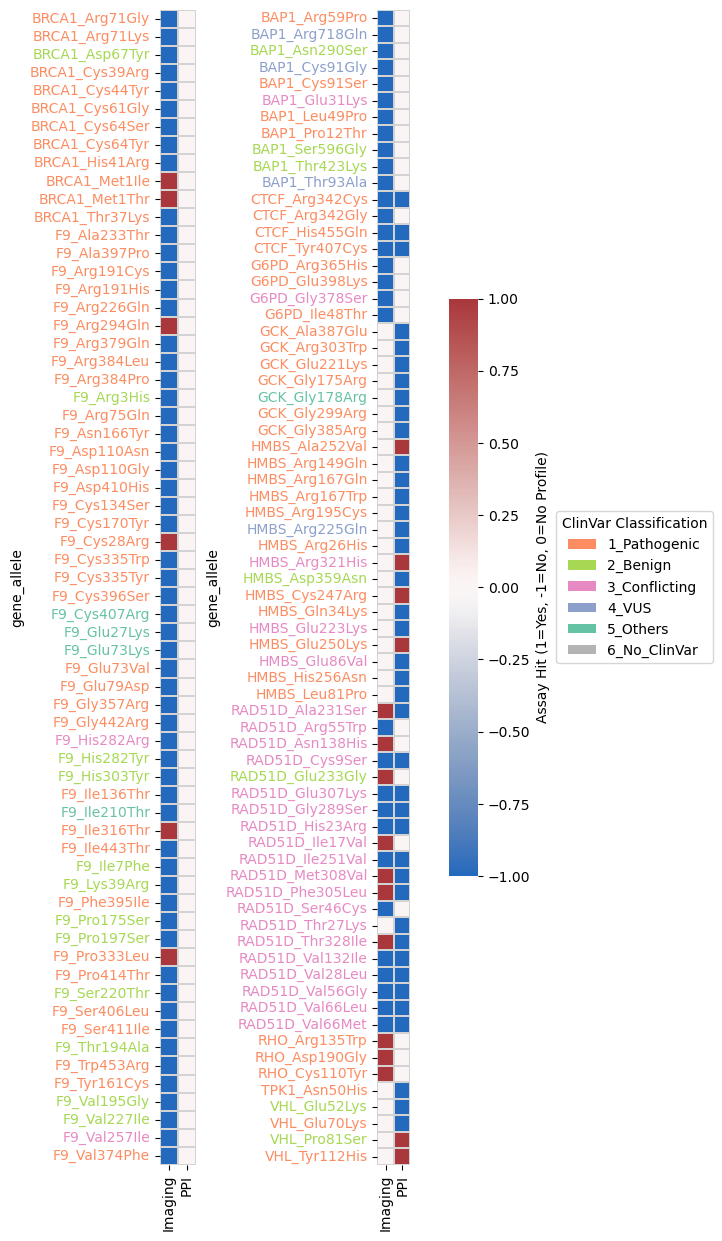

<Figure size 800x1000 with 0 Axes>

<Figure size 800x1000 with 0 Axes>

In [14]:
# Convert boolean columns to int for heatmap
heatmap_data_ = df_pandas[['Imaging', 'PPI']].astype(int)

# Create color mapping for clinvar categories
clinvar_categories = df_pandas['clinvar_clnsig_clean'].unique()
clinvar_color_map = palette_dict["clinvar_clnsig_clean"]

heatmap_data_1 = heatmap_data_.loc[[x for x in heatmap_data_.index if "F9" in x or "BRCA1" in x],:]
heatmap_data_2 = heatmap_data_.loc[[x for x in heatmap_data_.index if "F9" not in x and "BRCA1" not in x],:]

fig, ax = plt.subplots(1,2,figsize=(10,15))
for i, heatmap_data in enumerate([heatmap_data_1, heatmap_data_2]):
    # Create the heatmap
    plt.figure(figsize=(8, 10))
    sns.heatmap(
       heatmap_data,
       cmap='vlag',
       center=0.,
       vmin=-1,
       vmax=1,
       cbar_kws={'label': 'Assay Hit (1=Yes, -1=No, 0=No Profile)', 'shrink': 0.5},
       xticklabels=True,
       yticklabels=True,
       ax=ax[i],
        linewidths=.1,
        linecolor="lightgrey",
        cbar=(i==1),
        square=True,
    )
    # Color the y-axis tick labels based on clinvar classification
    for tick, gene_allele in zip(ax[i].get_yticklabels(), heatmap_data.index):
       clinvar_class = df_pandas.loc[gene_allele, 'clinvar_clnsig_clean']
       tick.set_color(clinvar_color_map[clinvar_class])

# Create legend for clinvar colors
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, label=cat) 
                 for cat, color in clinvar_color_map.items()]
ax[1].legend(handles=legend_elements, 
         title='ClinVar Classification',
         bbox_to_anchor=(5.2, .5), 
         loc='center left')

# plt.xlabel('Assay Type')
# plt.ylabel('Gene Allele')
plt.tight_layout()
fig.subplots_adjust(wspace=-1)
plt.show()

Text(0.5, 1.0, '134 Variants from 11 Genes Overlapped with Pillar')

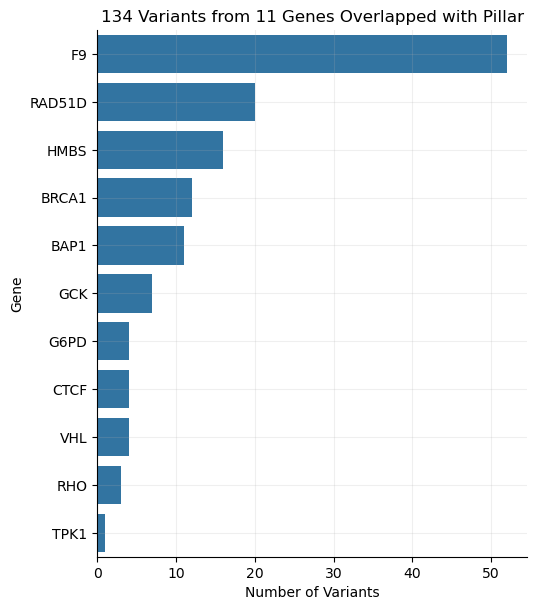

In [15]:
g = sns.catplot(data=img_ppi_df_in_pillar.unique(
    "gene_allele"
).group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
            x="Number of Variants", y="Gene", kind="bar", height=6, aspect=.9)
g.ax.grid(alpha=.2)
plt.title(f"{img_ppi_df_in_pillar.unique('gene_allele').shape[0]} Variants from {img_ppi_df_in_pillar.unique('Gene').shape[0]} Genes Overlapped with Pillar")

In [16]:
rad51d_allele = ppi_sum_df.filter(
    pl.col("gene_variant").is_in(
        img_ppi_df_in_pillar.filter(
            (pl.col("Imaging")!=0) & (pl.col("PPI")!=0)
        ).unique("gene_allele")["gene_allele"]
    ),
    pl.col("gene_variant").str.contains("RAD51D")
)

In [17]:
import requests
import gzip

def get_uniprot_swissprot_id(protein_name: str) -> str:
    """
    Query UniProt’s REST search API to find the reviewed (Swiss‐Prot) accession
    for a given human gene/protein name. Returns None if not found.
    """
    url = "https://rest.uniprot.org/uniprotkb/search"
    # Build a query that:
    #  - matches the gene name exactly (using “gene:”)
    #  - restricts to human (organism_id:9606)
    #  - restricts to reviewed (Swiss‐Prot) entries
    query = f"gene:{protein_name} AND organism_id:9606 AND reviewed:true"
    params = {
        "query": query,
        "fields": "accession",
        "format": "json",
        "size": 1,      # only need the top hit
    }
    try:
        resp = requests.get(url, params=params, timeout=10)
        resp.raise_for_status()
        data = resp.json()
        results = data.get("results", [])
        if not results:
            return None
        return results[0]["primaryAccession"]
    except Exception:
        # If the request fails (e.g. no internet), return None
        return None

gene = "RAD51D"
gene_uniprot_id = get_uniprot_swissprot_id(gene)
print(f"UniProt Swiss‐Prot ID for {gene}:", {gene_uniprot_id} or "Not found")

UniProt Swiss‐Prot ID for RAD51D: {'O75771'}


In [18]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
import requests
import glob
import gzip
import re
import os
import py3Dmol
from Bio.PDB import PDBParser

af2_struc_pdb_dir = "/data/shenrunx/igvf/varchamp/2025_laval_submitted/compare_ai_scores/1_inputs/new_raw_data/alphafold/UP000005640_9606_HUMAN_v4"

pdb_file = [pdb for pdb in glob.glob(f"{af2_struc_pdb_dir}/*.pdb.gz") if gene_uniprot_id in pdb][0]
pdb_file

# 1. Parse the structure
# 1) Open the .pdb.gz file with gzip.open in text/binary mode:
with gzip.open(pdb_file, "rt") as handle:
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("rho", handle)

    # 3. Rewind and read the entire PDB text
    handle.seek(0)
    pdb_text = handle.read()

# 2. Build a map: residue_number → (x, y, z) of its Cα atom
ca_coords = {}
for model in structure:
    for chain in model:
        if chain.get_id() == "A":
            for residue in chain:
                resnum = residue.get_id()[1]
                # Only consider standard amino acids with a CA atom
                if 'CA' in residue:
                    atom_ca = residue['CA']
                    ca_coords[resnum] = atom_ca.get_coord()

# 2) List of variants in “RHO_AminoAcidResidueNumberNewAminoAcid” format.
#    We assume that the PDB’s residue numbering matches exactly the numbers in these strings.
variants_raw = rad51d_allele.filter(pl.col("gene_allele").str.contains(f"{gene}_"))["gene_allele"].unique()
# 3) The chain ID in the PDB that contains Rhodopsin.
#    If your PDB uses a different chain (e.g. “B”), adjust accordingly.
chain_id = "A"
# 4) If your PDB has insertion codes (e.g. 106A, 106B), you must handle that.
#    In this example, we assume no insertion codes (icode = " ").
default_icode = " "
# Confirm chain exists
model = structure[0]  # first (and usually only) model
if chain_id not in model:
    raise ValueError(f"Chain '{chain_id}' not found in {pdb_file}.")
# ---- STEP 2: Convert each raw‐string into (chain, resi, icode, label) ----
variant_list = []
pattern = re.compile(rf"{gene}_([A-Za-z]{{3}})(\d+)([A-Za-z]{{3}})")
for raw in variants_raw:
    m = pattern.match(raw)
    if not m:
        print(f"Warning: '{raw}' does not match expected pattern 'RHO_Aaa###Bbb'. Skipping.")
        continue
    wt_3letter, resi_str, mut_3letter = m.groups()
    resi = int(resi_str)
    # Convert three‐letter codes to one‐letter for a concise label if you like.
    # Here, we'll keep the original string as the label.
    label = raw
    variant_list.append({
        "chain": chain_id,
        "resi": resi,
        "icode": default_icode,
        "label": label
    })

print(variant_list)
if not variant_list:
    raise RuntimeError("No valid variants found. Please check your variant strings.")

[{'chain': 'A', 'resi': 28, 'icode': ' ', 'label': 'RAD51D_Val28Leu'}, {'chain': 'A', 'resi': 305, 'icode': ' ', 'label': 'RAD51D_Phe305Leu'}, {'chain': 'A', 'resi': 308, 'icode': ' ', 'label': 'RAD51D_Met308Val'}, {'chain': 'A', 'resi': 231, 'icode': ' ', 'label': 'RAD51D_Ala231Ser'}, {'chain': 'A', 'resi': 66, 'icode': ' ', 'label': 'RAD51D_Val66Leu'}, {'chain': 'A', 'resi': 251, 'icode': ' ', 'label': 'RAD51D_Ile251Val'}, {'chain': 'A', 'resi': 328, 'icode': ' ', 'label': 'RAD51D_Thr328Ile'}, {'chain': 'A', 'resi': 66, 'icode': ' ', 'label': 'RAD51D_Val66Met'}, {'chain': 'A', 'resi': 307, 'icode': ' ', 'label': 'RAD51D_Glu307Lys'}, {'chain': 'A', 'resi': 132, 'icode': ' ', 'label': 'RAD51D_Val132Ile'}, {'chain': 'A', 'resi': 23, 'icode': ' ', 'label': 'RAD51D_His23Arg'}, {'chain': 'A', 'resi': 289, 'icode': ' ', 'label': 'RAD51D_Gly289Ser'}, {'chain': 'A', 'resi': 56, 'icode': ' ', 'label': 'RAD51D_Val56Gly'}, {'chain': 'A', 'resi': 9, 'icode': ' ', 'label': 'RAD51D_Cys9Ser'}]


In [19]:
# Define 3D offsets for each residue
offsets_3d = {
    135: {'x': +1.0, 'y': +0.5, 'z': +0.5},
    110: {'x': -1.0, 'y': +0.5, 'z': +0.5},
    190: {'x':  0.0, 'y': -1.0, 'z': +0.5}
}

view = py3Dmol.view(width=800, height=600)
view.addModel(pdb_text, 'pdb')
view.setStyle({'cartoon': {'color': 'spectrum'}})

residues_to_label = [var['resi'] for var in variant_list]
# Get atom coordinates first to calculate proper offsets
for i, resi in enumerate(residues_to_label):
    view.setStyle({'chain': 'A', 'resi': resi}, {'sphere': {'color': 'red', 'radius': .5}})
    # Add a dummy atom at offset position for labeling
    # This requires knowing the actual coordinates
    view.addResLabels(
        {'chain': 'A', 'resi': residues_to_label},
        {'fontColor': 'red', 'fontSize': 15, 'showBg': False}
    )
    
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [103]:
img_ppi_df.filter(
   pl.col("gene_allele").is_in(pillar_clinvar_df["gene_variant"]),
).with_columns(
   pl.when(pl.col("Altered_95th_perc_both_batches_GFP").is_null())
   .then(0)
   .when(pl.col("Altered_95th_perc_both_batches_GFP"))
   .then(1)
   .otherwise(-1)
   .alias("Imaging"),
   pl.when(pl.col("ppi_perturbed_llr").is_null())
   .then(0)
   .when(pl.col("ppi_perturbed_llr"))
   .then(1)
   .otherwise(-1)
   .alias("PPI"),
    pl.col("gene_allele").str.split("_").list.get(0).alias("Gene"),
)

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_prot_abun_t_stat,U2OS_prot_abun_t_pval,Metadata_Bio_Batch,Altered_95th_perc_both_batches_GFP,Altered_95th_perc_both_batches_DNA,Altered_95th_perc_both_batches_Mito,Altered_95th_perc_both_batches_AGP,Altered_95th_perc_both_batches_Morph,Altered_99th_perc_both_batches_GFP,Altered_99th_perc_both_batches_DNA,Altered_99th_perc_both_batches_Mito,Altered_99th_perc_both_batches_AGP,Altered_99th_perc_both_batches_Morph,AUROC_Mean_GFP,AUROC_Mean_DNA,AUROC_Mean_Mito,AUROC_Mean_AGP,AUROC_Mean_Morph,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep1_GFP,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_BioRep2_GFP,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,…,protein_00001033-a-1 outliers⁺⁺_right,protein_00001034-a-1 avg_right,protein_00001034-a-1 outliers⁺⁺_right,protein_00000959-a-1 avg_right,protein_00000959-a-1 outliers⁺⁺_right,protein_00001177-a-1 avg_right,protein_00001177-a-1 outliers⁺⁺_right,protein_00000001-d-2 avg_right,protein_00000001-d-2 outliers⁺⁺_right,protein_00000966-a-1 avg_right,protein_00000966-a-1 outliers⁺⁺_right,protein_00000013-a-1 avg_right,protein_00000013-a-1 outliers⁺⁺_right,protein_00000101-a-1 avg_right,protein_00000101-a-1 outliers⁺⁺_right,protein_00000102-0-1 avg_right,protein_00000102-0-1 outliers⁺⁺_right,protein_00000745-a-1 avg_right,protein_00000745-a-1 outliers⁺⁺_right,protein_00000746-a-1 avg_right,protein_00000746-a-1 outliers⁺⁺_right,protein_00001065-a-1 avg_right,protein_00001065-a-1 outliers⁺⁺_right,protein_00000686-a-1 avg_right,protein_00000686-a-1 outliers⁺⁺_right,protein_00001112-a-1 avg_right,protein_00001112-a-1 outliers⁺⁺_right,seq_confirmed_wt_ppi,seq_confirmed_allele_ppi,seq_confirmed_final,chr,chr_pos_38,ppi_perturbed_manual,ppi_perturbed_llr,Gene_right,Imaging,PPI
str,str,f64,f64,f64,f64,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,i64,f64,str,…,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,bool,bool,str,i32,i32
"""VHL""","""VHL_Pro81Ser""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,"""VHL""",0,1
"""HMBS""","""HMBS_Arg321His""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,"""HMBS""",0,1
"""HMBS""","""HMBS_Arg167Trp""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false,false,"""HMBS""",0,-1
"""HMBS""","""HMBS_Arg225Gln""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false,false,"""HMBS""",0,-1
"""RAD51D""","""RAD51D_Ala231Ser""",0.248881,0.810597,15.706225,0.000001,"""2025_01_Batch_13-14""",true,false,false,false,false,false,false,false,false,false,0.961174,0.76321,0.858034,0.847925,0.747141,0.612421,0.794866,0.779003,0.682607,0.961714,0

In [87]:
img_feats = [f"AUROC_Mean_{feat}" for feat in IMG_FEAT_SET]+[f"Altered_95th_perc_{feat}" for feat in IMG_FEAT_SET]
dualipa_feats = ["dualipa_abund_change", "dualipa_threshold", "abund_zscore"]
ppi_feats = ["total_occurrences","not_perturbed_count","inconclusive_count","perturbed_count",
             "not_perturbed_percentage","inconclusive_percentage","perturbed_percentage"]
rename_dict = {
    "abund_zscore": "dualipa_abund_zscore",
}
for feat in img_feats:
    rename_dict[feat] = "imaging_"+feat
for feat in ppi_feats:
    rename_dict[feat] = "ppi_"+feat
    
img_dual_ppi_pillar_df = img_dual_ppi_df.filter(
    (pl.col("gene_variant").is_in(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["gene_variant"]))# & (pl.col("gene_variant").is_in(pillar_clinvar_df["gene_variant"].unique())) ## .filter(pl.col("pillar_tested"))
).select(
    ["gene_variant","clinvar_clnsig_clean","spdi"]+img_feats+dualipa_feats+ppi_feats
).rename(rename_dict)

img_dual_ppi_pillar_df.write_csv("../3_outputs/img_dual_ppi_dms_overlapped_alleles.csv")

In [88]:
img_dual_ppi_pillar_df

gene_variant,clinvar_clnsig_clean,spdi,imaging_AUROC_Mean_GFP,imaging_AUROC_Mean_Morph,imaging_AUROC_Mean_DNA,imaging_AUROC_Mean_Mito,imaging_AUROC_Mean_AGP,imaging_Altered_95th_perc_GFP,imaging_Altered_95th_perc_Morph,imaging_Altered_95th_perc_DNA,imaging_Altered_95th_perc_Mito,imaging_Altered_95th_perc_AGP,dualipa_abund_change,dualipa_threshold,dualipa_abund_zscore,ppi_total_occurrences,ppi_not_perturbed_count,ppi_inconclusive_count,ppi_perturbed_count,ppi_not_perturbed_percentage,ppi_inconclusive_percentage,ppi_perturbed_percentage
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,f64,f64,i64,i64,i64,i64,f64,f64,f64
"""F9_Phe395Ile""","""1_Pathogenic""","""NC_000023.11:139561868:T:A""",0.875349,0.649607,0.658657,0.85295,0.759263,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null
"""RAD51D_Glu233Gly""","""2_Benign""","""NC_000017.11:35103294:T:C""",0.964322,0.674513,0.705775,0.919104,0.885253,1.0,0.0,0.0,0.0,0.0,false,-2.884438,1.286316,null,null,null,null,null,null,null
"""BRCA1_Cys64Tyr""","""1_Pathogenic""","""NC_000017.11:43106477:C:T""",0.922977,0.930471,0.805035,0.873185,0.961233,0.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null
"""G6PD_Gly378Ser""","""3_Conflicting""","""NC_000023.11:154532722:C:T""",0.696318,0.472079,0.489431,0.615492,0.560513,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null
"""BRCA1_Pro533Leu""","""2_Benign""","""NC_000017.11:43071004:G:A""",0.886511,0.943972,0.855476,0.934251,0.908372,0.0,1.0,1.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""MSH2_Leu421Pro""","""4_VUS""","""NC_000002.12:47429927:T:C""",null,null,null,null,null,null,null,null,null,null,false,-2.884438,-0.021206,null,null,null,null,null,null,null
"""HMBS_Ala252Val""","""1_Pathogenic""","""NC_000011.10:119092507:C:T""",null,null,null,null,null,null,null,null,null,null,null,null,null,1,0,0,1,0.0,0.0,100.0
"""HMBS_His256Asn""","""1_Pathogenic""","""NC_000011.10:119092518:C:A""",null,null,null,null,null,null,null,null,null,null,null,null,null,1,1,0,0,100.0,0.0,0.0


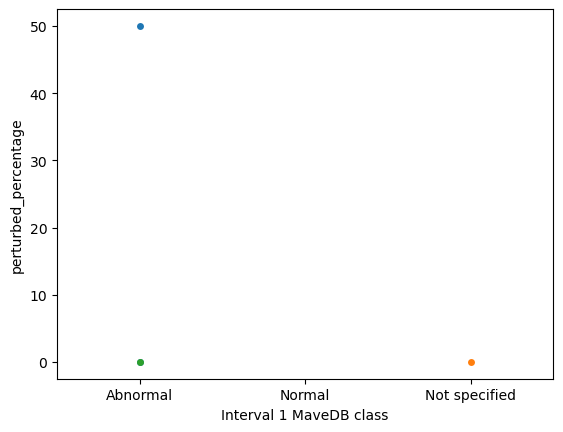

In [90]:
for i in range(1,7):
    sns.swarmplot(
        data=img_dual_ppi_df.filter(
            (pl.col("gene_variant").is_in(pillar_varchamp_df_variant_reannot.filter(pl.col("pillar_tested"))["gene_variant"]))# & (pl.col("gene_variant").is_in(pillar_clinvar_df["gene_variant"].unique())) ## .filter(pl.col("pillar_tested"))
        ).to_pandas(),
        x=f"Interval {i} MaveDB class",
        y="perturbed_percentage"
    )

## 2. Hits calling

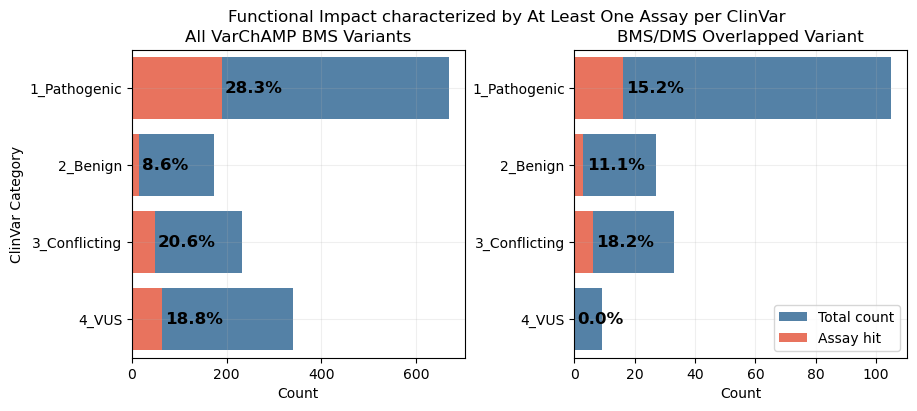

In [71]:
img_dual_ppi_df = img_dual_ppi_df.with_columns(
    pl.any_horizontal(["img_prot_hits_5perc", f"ppi_pert_hits_{ppi_threshold}", "dualipa_abund_change"]).alias("assay_hit")
)

img_dual_ppi_clinvar_clean_all = img_dual_ppi_df.unique("gene_variant").filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)

img_dual_ppi_clinvar_clean_hits_all = img_dual_ppi_df.filter(
    (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])) & (pl.col("assay_hit"))
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)
img_dual_ppi_by_gene_cv_hits_all = img_dual_ppi_clinvar_clean_all.join(
    img_dual_ppi_clinvar_clean_hits_all,
    on=["clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)
# img_dual_ppi_by_gene_cv_hits_all.sort("clinvar_clnsig_clean")

fig, axes = plt.subplots(1,2,figsize=(10,4))
plot_df = img_dual_ppi_by_gene_cv_hits_all.sort("clinvar_clnsig_clean").to_pandas()
sns.barplot(plot_df, y="clinvar_clnsig_clean",x="total_counts", ax=axes[0], color="steelblue")
sns.barplot(plot_df, y="clinvar_clnsig_clean",x="hit_counts", color="tomato", ax=axes[0])
axes[0].set_title("All VarChAMP BMS Variants")
# Add percentage annotations
for i, row in plot_df.iterrows():
    # Position the text at the end of the red (hit_counts) bar
    axes[0].text(row['hit_counts'] + max(plot_df['total_counts']) * 0.01,  # slight offset from bar end
            i,  # y position (bar index)
            f"{row['hit_perc']:.1f}%",  # percentage text
            va='center',  # vertical alignment
            ha='left',   # horizontal alignment
            fontweight='bold',
           fontsize=12,
           color="black")
axes[0].grid(alpha=.2)

img_dual_ppi_clinvar_clean_all = img_dual_ppi_df.unique("gene_variant").filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])
    & pl.col("gene_variant").is_in(common_variants)
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)

img_dual_ppi_clinvar_clean_hits_all = img_dual_ppi_df.filter(
    (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])) & (pl.col("assay_hit"))
    & pl.col("gene_variant").is_in(common_variants)
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)
img_dual_ppi_by_gene_cv_hits_all = img_dual_ppi_clinvar_clean_all.join(
    img_dual_ppi_clinvar_clean_hits_all,
    on=["clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)
img_dual_ppi_by_gene_cv_hits_all.sort("clinvar_clnsig_clean")

plot_df = img_dual_ppi_by_gene_cv_hits_all.sort("clinvar_clnsig_clean").to_pandas()
sns.barplot(plot_df, y="clinvar_clnsig_clean",x="total_counts", ax=axes[1],
           label="Total count", color="steelblue")
sns.barplot(plot_df, y="clinvar_clnsig_clean",x="hit_counts", ax=axes[1],
           label="Assay hit", color="tomato")
axes[1].set_title("BMS/DMS Overlapped Variant")
# Add percentage annotations
for i, row in plot_df.iterrows():
    # Position the text at the end of the red (hit_counts) bar
    axes[1].text(row['hit_counts'] + max(plot_df['total_counts']) * 0.01,  # slight offset from bar end
            i,  # y position (bar index)
            f"{row['hit_perc']:.1f}%",  # percentage text
            va='center',  # vertical alignment
            ha='left',   # horizontal alignment
            fontweight='bold',
           fontsize=12,
           color="black")

img_dual_ppi_clinvar_clean_all = img_dual_ppi_df.unique("gene_variant").filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign","3_Conflicting","4_VUS"])
    & pl.col("gene_variant").is_in(common_variants)
).group_by(
    ["clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)
axes[1].legend(loc="lower right")
axes[1].grid(alpha=.2)
axes[1].set_ylabel("")

axes[0].set_ylabel("ClinVar Category")
axes[1].set_xlabel("Count")
axes[0].set_xlabel("Count")

plt.suptitle("Functional Impact characterized by At Least One Assay per ClinVar")
plt.subplots_adjust(wspace=0.33)

In [269]:
img_dual_ppi_clinvar_clean = img_dual_ppi_df.filter(
    pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign"])
).group_by(
    ["symbol","clinvar_clnsig_clean"]
).len().rename(
    {"len": "total_counts"}
)

img_dual_ppi_clinvar_clean_hits = img_dual_ppi_df.filter(
    (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic","2_Benign"])) & (pl.col("assay_hit"))
).group_by(
    ["symbol","clinvar_clnsig_clean"]
).len().rename(
    {"len": "hit_counts"}
)

img_dual_ppi_by_gene_cv_hits = img_dual_ppi_clinvar_clean.join(
    img_dual_ppi_clinvar_clean_hits,
    on=["symbol","clinvar_clnsig_clean"],
    how="left"
).fill_null(0).with_columns(
    (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
)

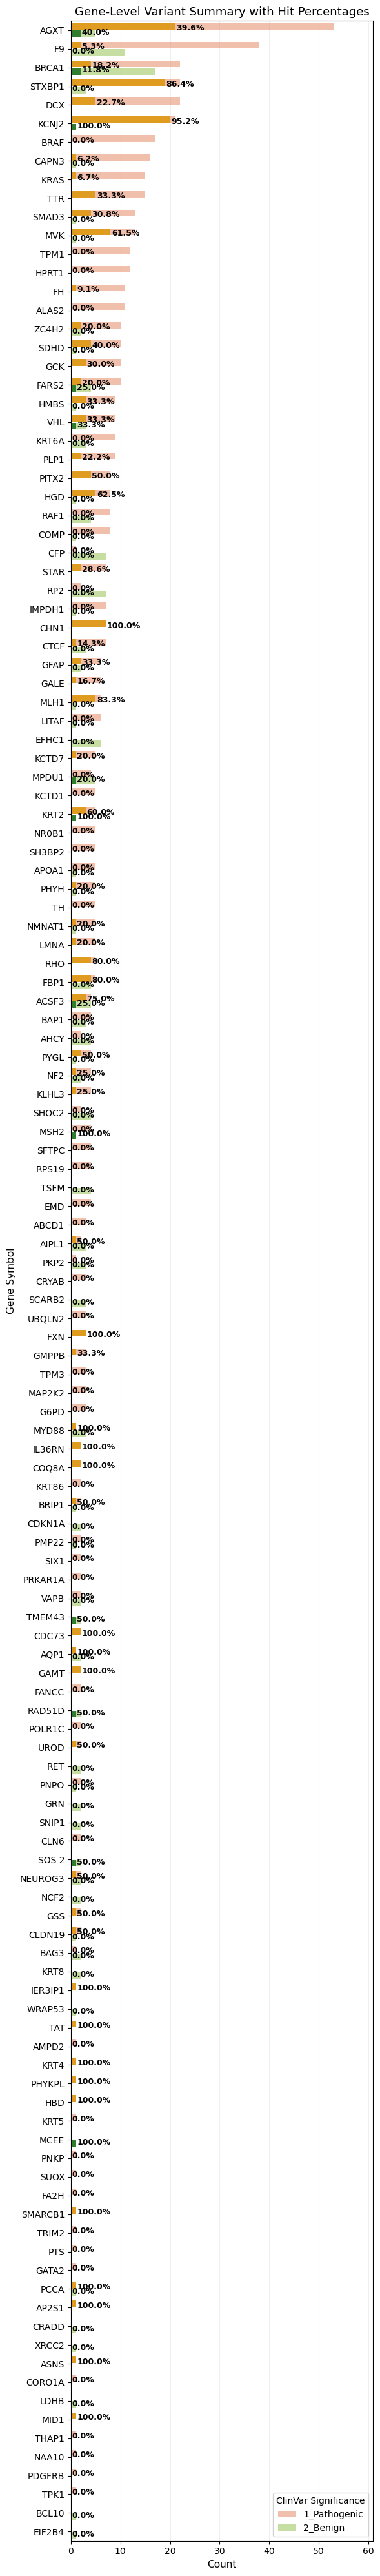

,symbol,clinvar_clnsig_clean,total_counts,hit_counts,hit_perc
0,AGXT,1_Pathogenic,53,21,39.622642
1,F9,1_Pathogenic,38,2,5.263158
2,BRCA1,1_Pathogenic,22,4,18.181818
3,STXBP1,1_Pathogenic,22,19,86.363636
4,DCX,1_Pathogenic,22,5,22.727273
...,...,...,...,...,...
179,LITAF,2_Benign,1,0,0.000000
180,BCL10,2_Benign,1,0,0.000000
181,IMPDH1,2_Benign,1,0,0.000000
182,EIF2B4,2_Benign,1,0,0.000000


In [273]:
# fig, ax = plt.subplots(1,1,figsize=(7,15))
plot_gene_level_summary(img_dual_ppi_by_gene_cv_hits)

In [300]:
img_dual_ppi_df_scores = img_dual_ppi_df.with_columns(
    pl.when(pl.col("clinvar_clnsig_clean")=="1_Pathogenic")
    .then(pl.lit(1))
    .when(pl.col("clinvar_clnsig_clean")=="2_Benign")
    .then(pl.lit(0))
    .otherwise(None)
    .alias("1_Pathogenic"),
    pl.col("abund_zscore").neg().alias("abun_change_score")
).drop_nulls(
    pl.col("1_Pathogenic")
)

# img_dual_ppi_df["perturbed_percentage"].unique()

In [295]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
set2_palette = sns.color_palette("Set2")

def compute_aubprc(auprc, prior):
    return (auprc*(1-prior))/((auprc*(1-prior)) + ((1-auprc)*prior))


def plot_auroc_curves(df_clinvar_w_scores, pos_label, methods, set2_palette=set2_palette):
    """
    For each method, plot the adjusted PR curve (with both balanced and monotonized adjustments)
    and compute the adjusted AUPRC via bootstrapping. Also perform pairwise significance testing 
    of the AUPRC across different RSA categories.
    
    Parameters
    ----------
    df_clinvar_w_scores : Polars DataFrame
        Input data including columns "clinvar_clnsig_clean", category and predictor scores.
    methods : list of str
        List of method names corresponding to score columns in the data.
    set2_palette : list of str
        List of colors (e.g., from a color palette) to use for different RSA categories.
    n_bootstrap : int, optional
        Number of bootstrap iterations for significance testing (default is 1000).
    random_state : int or None, optional
        Seed for reproducibility.
    
    Returns
    -------
    ap_results : dict
        Dictionary of adjusted AUPRC values and bootstrap distributions, structured as:
          { method: { category: {"AP": <adjusted AUPRC>, "boot_ap": <bootstrap array> } } }
    significance : dict
        Dictionary mapping each method to a DataFrame of pairwise p-values comparing AUPRC between categories.
    """
    fig, axes = plt.subplots(1, 1, figsize=(6, 5))
        
    ap_results = {}  # to store adjusted AUPRC and bootstrap distributions
    # significance = {}  # to store pairwise significance p-values per method
    
    for m_idx, met in enumerate(methods):
        ap_results[met] = {}
        # Filter data for current category and valid clinical labels.
        df_clin_per_method = df_clinvar_w_scores.filter(
            (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic", "2_Benign"]))
        ).with_columns(
            (
                pl.when(pl.col("clinvar_clnsig_clean") == pos_label)
                .then(1)
                .otherwise(0)
            ).alias("clinvar_label")
        ).drop_nulls(subset=["clinvar_clnsig_clean", met])
        
        # Convert to pandas DataFrame.
        df_pd = df_clin_per_method.to_pandas()
        df_pd = df_pd[["clinvar_label", met]].dropna()
        # Convert clinvar_label to boolean.
        truth = df_pd["clinvar_label"].astype(bool)
        # Create a scores DataFrame (with one column).
        scores = df_pd[[met]]
        # Create the YogiROC2 object using the new YogiROC2() constructor.
        fpr, tpr, thresholds = roc_curve(truth, scores)
        # Get the performance table from the YogiROC2 object.
        auc_score = roc_auc_score(truth, scores)
        ap_results[met] = auc_score

        # Plot the adjusted PR curve.
        axes.plot(100 * fpr, 100 * tpr,
                label=f"{met}: {auc_score:.2f}",
                color=set2_palette[methods.index(met)])
        # Plot chance level as a horizontal dashed line.
        # axes[m_idx].axhline(y=100 * prior, color=set2_palette[plddt_cats.index(cat)], ls="--")
    # Customize the subplot.
    handles, labels = axes.get_legend_handles_labels()
    # order = [2,1,0] if "rsa" in category else [3,1,0,2]
    precision_label = "True Positive Rate (%)"
    # title = f"AUROC by {category}"
    
    axes.legend(loc="lower right",
                    title="Assay")
    axes.set_xlabel("False Positive Rate (%)")
    axes.set_ylabel(precision_label)
    # axes[m_idx].set_title(met.split("_")[0])
    axes.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()
    # plt.subplots_adjust(wspace=0.04)
    
    return ap_results ## , sig_results_dict

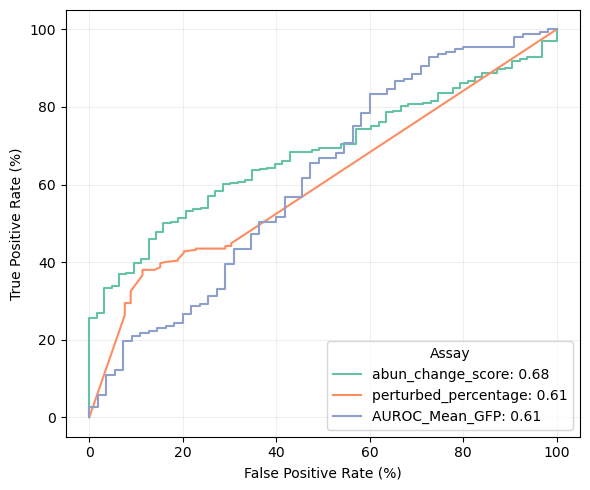

In [296]:
ap_results_dict = plot_auroc_curves(img_dual_ppi_df_scores, "1_Pathogenic", 
                                    methods=["abun_change_score", "perturbed_percentage", "AUROC_Mean_GFP"])

{'abun_change_score': {'AUPRC': np.float64(0.7514950280292664)},
 'ppi_pert_perc': {'AUPRC': np.float64(0.37519594860661115)},
 'AUROC_Mean_GFP': {'AUPRC': np.float64(0.6198348625712236)}}

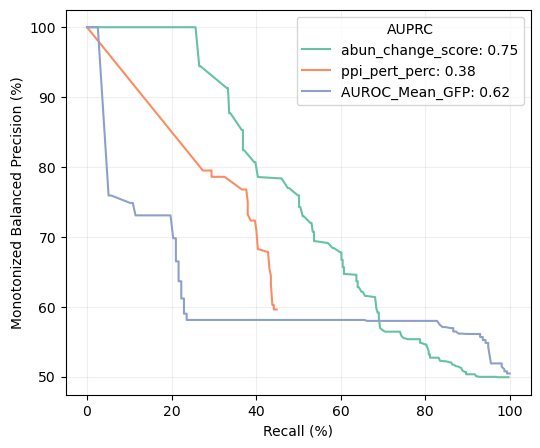

In [298]:
def plot_adjusted_pr_curves(df_clinvar_w_scores, pos_label, methods, monotonized_flag, balanced_flag, subsample=False, set2_palette=set2_palette, n_bootstrap=1000, random_state=None):
    """
    For each method, plot the adjusted PR curve (with both balanced and monotonized adjustments)
    and compute the adjusted AUPRC via bootstrapping. Also perform pairwise significance testing 
    of the AUPRC across different RSA categories.
    
    Parameters
    ----------
    df_clinvar_w_scores : Polars DataFrame
        Input data including columns "clinvar_clnsig_clean", category and predictor scores.
    methods : list of str
        List of method names corresponding to score columns in the data.
    set2_palette : list of str
        List of colors (e.g., from a color palette) to use for different RSA categories.
    n_bootstrap : int, optional
        Number of bootstrap iterations for significance testing (default is 1000).
    random_state : int or None, optional
        Seed for reproducibility.
    
    Returns
    -------
    ap_results : dict
        Dictionary of adjusted AUPRC values and bootstrap distributions, structured as:
          { method: { category: {"AP": <adjusted AUPRC>, "boot_ap": <bootstrap array> } } }
    significance : dict
        Dictionary mapping each method to a DataFrame of pairwise p-values comparing AUPRC between categories.
    """
    assert (balanced_flag and not subsample) or (subsample and not balanced_flag) or (not subsample and not balanced_flag)
    
    ap_results_dict = {}
    fig, axes = plt.subplots(1, 1, figsize=(6, 5))
    if len(methods) == 1:
        axes = [axes]
        
    ap_results = {}  # to store adjusted AUPRC and bootstrap distributions
    # significance = {}  # to store pairwise significance p-values per method
    
    for m_idx, met in enumerate(methods):
        ap_results[met] = {}
        
        # Filter data for current category and valid clinical labels.
        df_clin_per_method = df_clinvar_w_scores.filter(
            (pl.col("clinvar_clnsig_clean").is_in(["1_Pathogenic", "2_Benign"]))
        ).with_columns(
            pl.col(pos_label).alias("clinvar_label"),
            pl.col(met).cast(pl.Float64).alias(met)
        ).drop_nulls(subset=["clinvar_clnsig_clean", met])
        
        # Convert to pandas DataFrame.
        df_pd = df_clin_per_method.to_pandas()
        if subsample:
            # Assume df is your existing DataFrame with a column named "label"
            # Find the minimum count among the two classes (0 and 1)
            min_count = df_pd['clinvar_label'].value_counts().min()
            # Group by the 'label' column and sample min_count rows from each group (without replacement)
            df_pd = df_pd.groupby('clinvar_label').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

        # Convert clinvar_label to boolean.
        truth = df_pd["clinvar_label"].astype(bool)
        # Create a scores DataFrame (with one column).
        scores = df_pd[[met]]

        # Create the YogiROC2 object using the new YogiROC2() constructor.
        yrobj = YogiROC2(truth, scores, names=[met], high=True)
        # Get the performance table from the YogiROC2 object.
        table = yrobj.tables[met]

        if (monotonized_flag and balanced_flag):
            table = table.dropna()
            
        precision = configure_prec(table, monotonized_flag=monotonized_flag, balanced_flag=balanced_flag)
        recall = table["tpr_sens"].values
        ap = calc_auc(recall[~np.isnan(recall)], precision[~np.isnan(precision)])
        ap_results[met] = {"AUPRC": ap}

        # Plot the adjusted PR curve.
        axes.plot(100 * recall, 100 * precision,
                  label=f"{met}: {ap:.2f}",
                  color=set2_palette[methods.index(met)])
        # Plot chance level as a horizontal dashed line.
        prior = np.sum(truth) / df_pd.shape[0]
        if (not balanced_flag):
            axes.axhline(y=100 * prior, color=set2_palette[-1], ls="--")
        precision_label = "Precision (%)"
        title = f"AUPRC"
        if balanced_flag:
            precision_label = "Balanced " + precision_label
            # title = "Balanced " + title
        if monotonized_flag:
            precision_label = "Monotonized " + precision_label
            # title = "Balanced " + title

    # Customize the subplot.
    # handles, labels = axes[methods.index(met)].get_legend_handles_labels()
    axes.legend(loc="upper right", title=title)
    axes.set_xlabel("Recall (%)")
    axes.set_ylabel(precision_label)
    # axes.set_title(met.split("_")[0])
    axes.grid(alpha=.2)
    
    ap_results_dict = ap_results
    # # sig_results_dict[category] = significance
    # plt.tight_layout()
    # plt.show()
    # # plt.subplots_adjust(wspace=0.04)
    return ap_results_dict ## , sig_results_dict

plot_adjusted_pr_curves(
    img_dual_ppi_df_scores.with_columns(
        (pl.col("perturbed_percentage") / 100).alias("ppi_pert_perc")
    ), 
    pos_label="1_Pathogenic", 
    methods=["abun_change_score", "ppi_pert_perc", "AUROC_Mean_GFP"], 
    monotonized_flag=True, balanced_flag=True)

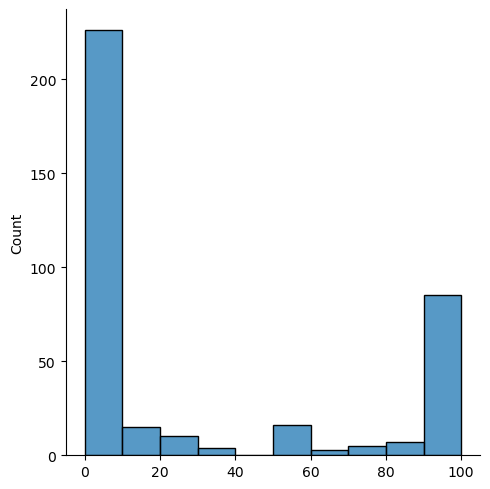

In [299]:
sns.displot(img_dual_ppi_df_scores["perturbed_percentage"])